In [50]:
import pandas as pd
import os
from typing import Any
import numpy as np
from sklearn.metrics import (
    make_scorer,
    mean_absolute_percentage_error,
    mean_absolute_error,
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from scikeras.wrappers import KerasRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping

np.random.seed(42)
OVERWRITE = False

# Loading data

## Load

In [51]:
marathon_df = pd.read_csv('data/marathon_dataset.csv')
marathon_df['bmi'] = marathon_df['weight'] / (marathon_df['height']**2)

halfmarathon_df = pd.read_csv('data/halfmarathon_dataset.csv')
halfmarathon_df['bmi'] = halfmarathon_df['weight'] / (halfmarathon_df['height']**2)

df = pd.concat([marathon_df,halfmarathon_df]).reset_index(drop=True)
df.columns

marathon_df = marathon_df.drop(['distance','first distance','second distance'],errors='ignore',axis=1)
halfmarathon_df = halfmarathon_df.drop(['distance','first distance','second distance'],errors='ignore',axis=1)

# EDA

## Matrathons

In [52]:
marathon_df.describe()

age       weight       height         time   first time  \
count  4276.000000  4276.000000  4276.000000  4276.000000  4276.000000   
mean     41.661366    65.453461     1.747654   193.693339    86.075456   
std       9.430418     8.373192     0.073726    34.386863    11.170069   
min      20.000000    37.000000     1.500000   127.050000    59.983333   
25%      35.000000    61.000000     1.700000   170.833333    78.333333   
50%      41.000000    65.000000     1.750000   188.141667    84.866667   
75%      48.000000    71.000000     1.800000   209.604167    92.433333   
max      74.000000   104.000000     2.020000   501.783333   213.750000   

       first days before main event  second time  \
count                   4276.000000  4276.000000   
mean                      59.426567    38.380886   
std                       46.030272     4.508468   
min                        2.000000    27.150000   
25%                       28.000000    35.266667   
50%                       42.000000    37.983333   
75%                       70.000000    40.916667   
max                      180.000000    65.850000   

       second days before main event          bmi  
count                    4276.000000  4276.000000  
mean                       92.051450    21.370678  
std                        51.887527     1.903612  
min                         1.000000    16.014543  
25%                        48.000000    20.069204  
50%                        91.000000    21.303949  
75%                       140.000000    22.491349  
max                       180.000000    35.111111

C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\1861763397.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Male', 'Female'])


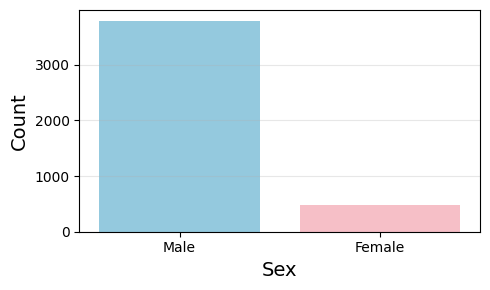

In [53]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.grid(alpha=0.3)
sns.countplot(data=marathon_df, x="sex", ax=ax, palette={'M': 'skyblue', 'F': 'lightpink'},hue='sex',legend=False)
ax.set_xlabel('Sex', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticklabels(['Male', 'Female'])
fig.tight_layout()
fig.savefig('figs/marathon_sex_countplot.pdf', dpi=300)


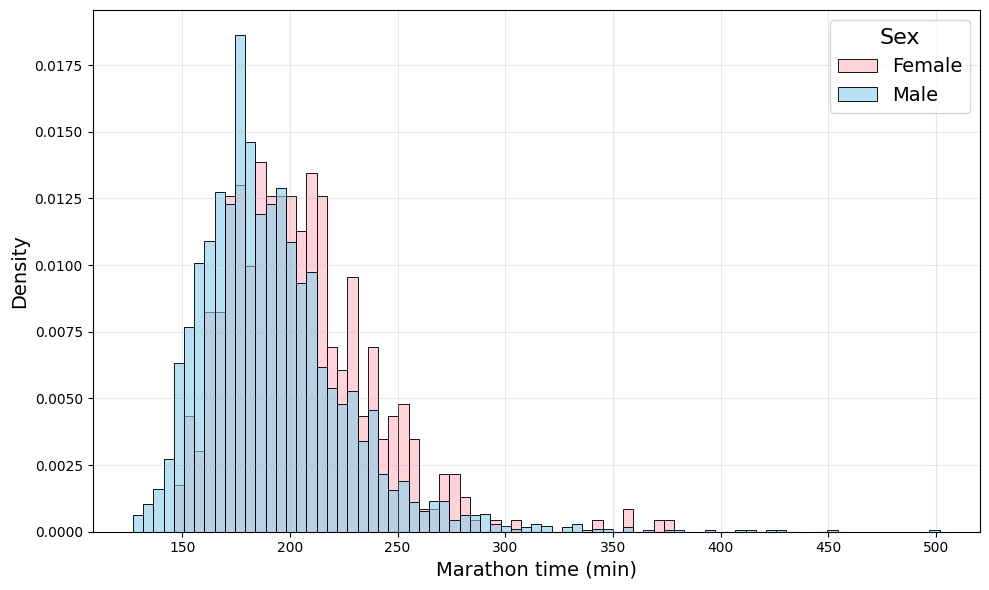

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(alpha=0.3)
sns.histplot(data=marathon_df, x="time", ax=ax, hue='sex', stat="density",
             palette={'M': 'skyblue', 'F': 'lightpink'},
             common_norm=False, alpha=0.6)  # This ensures density is calculated separately for each group
ax.set_xlabel('Marathon time (min)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
plt.legend(title='Sex', labels=['Female', 'Male'], fontsize=14, title_fontsize=16)
fig.tight_layout()
fig.savefig('figs/marathon_time.pdf', dpi=300)

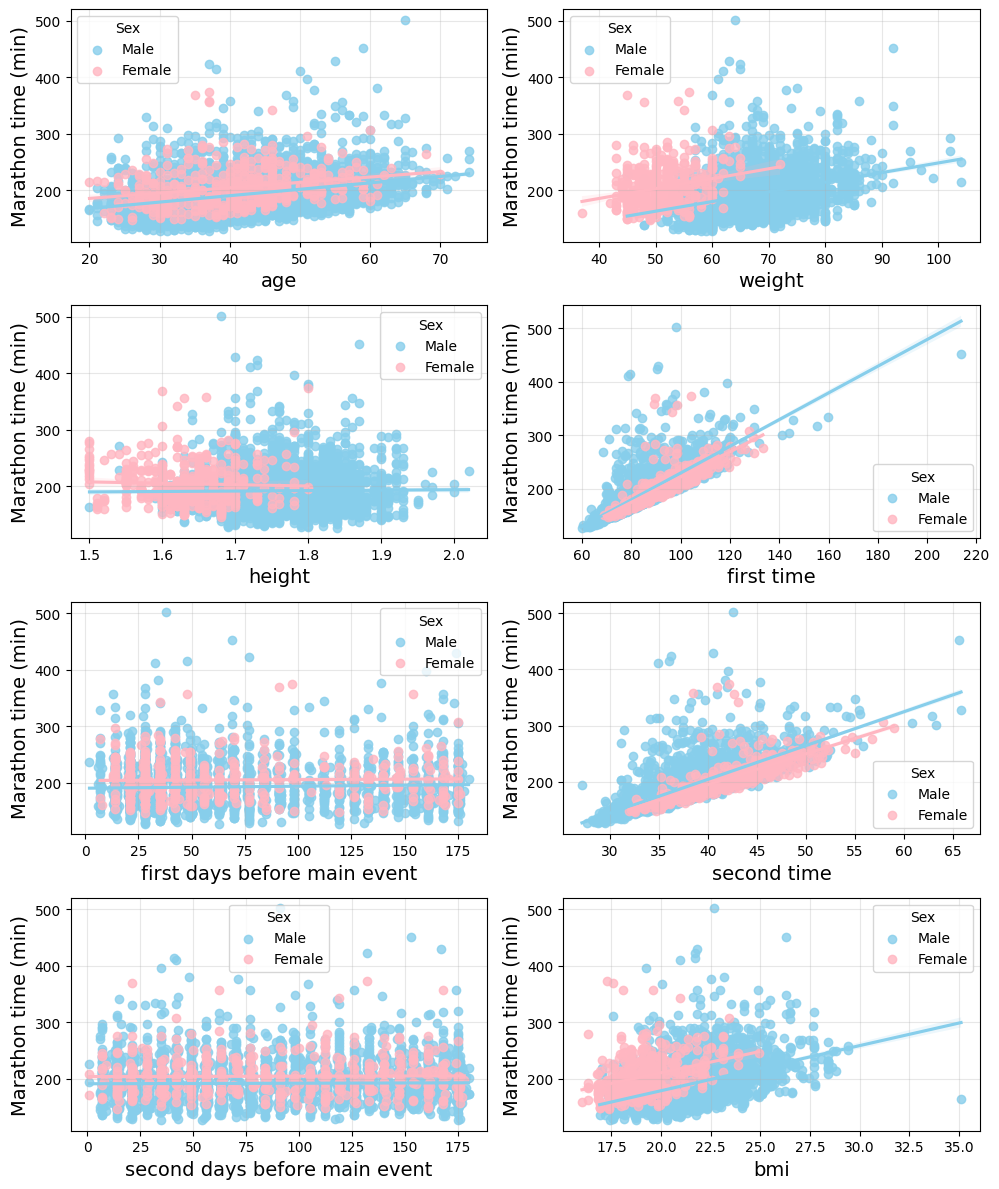

In [55]:
# Create a figure with 2 columns and multiple rows based on number of features
features = ['age', 'weight', 'height', 'bmi', 'first_time', 'first days before main event',
           'second_time', 'second days before main event']
features = marathon_df.drop(['time','sex'],axis=1).columns
n_features = len(features)
n_cols = 2
n_rows = (n_features + 1) // 2  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3*n_rows))
axes = axes.flatten()

# Plot each feature vs time
for idx, feature in enumerate(features):
    # Create scatter plot with regression line for each sex
    sns.regplot(data=marathon_df[marathon_df['sex']=='M'],
                x=feature, y='time', scatter=True,
                color='skyblue', ax=axes[idx], label='Male')
    sns.regplot(data=marathon_df[marathon_df['sex']=='F'],
                x=feature, y='time', scatter=True,
                color='lightpink', ax=axes[idx], label='Female')

    axes[idx].set_xlabel(feature, fontsize=14)
    axes[idx].set_ylabel('Marathon time (min)', fontsize=14)
    axes[idx].grid(alpha=0.3)

    # Create a single legend for both plots
    handles, labels = axes[idx].get_legend_handles_labels()
    axes[idx].legend(handles[:2], ['Male', 'Female'], title='Sex')

# Remove any empty subplots
for idx in range(len(features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('figs/marathon_feature_analysis.pdf', dpi=300)




C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\2472964040.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  correlation_matrix = marathon_df.replace(['M','F'],[0,1]).corr()


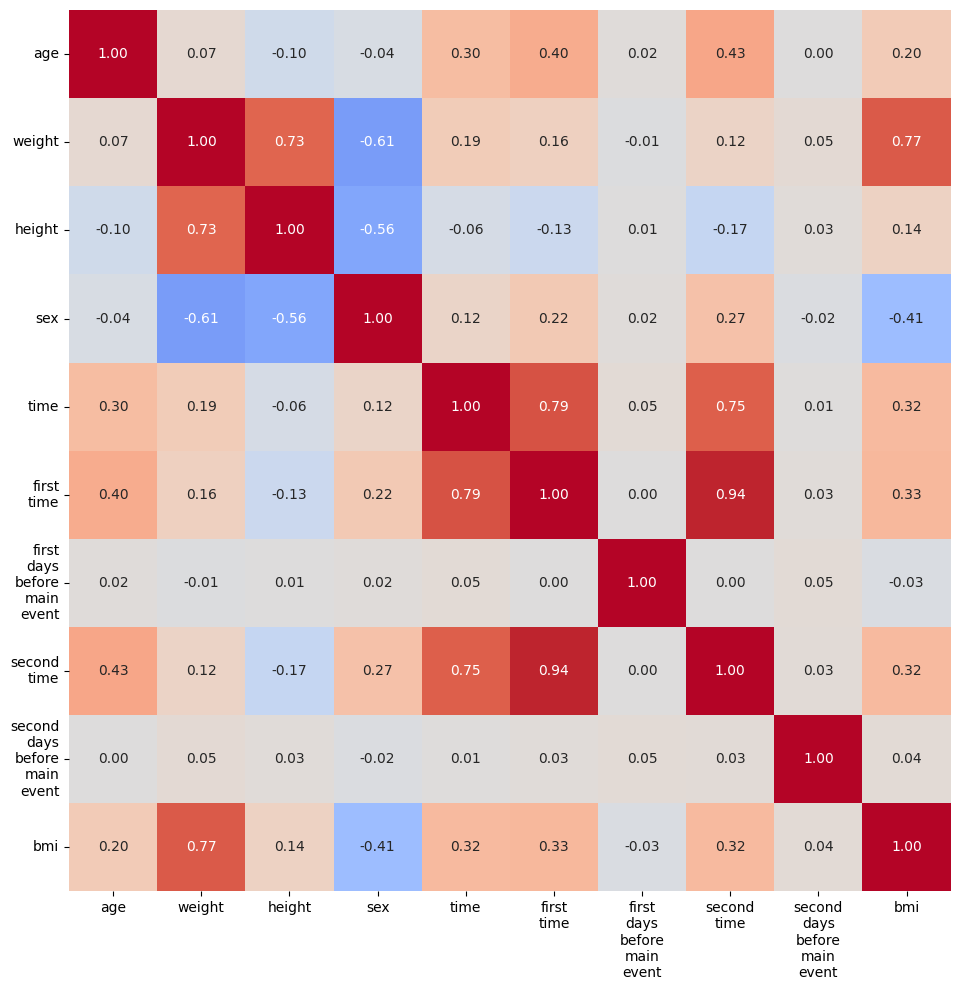

In [56]:
# Create correlation matrix
correlation_matrix = marathon_df.replace(['M','F'],[0,1]).corr()

# Create figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix,
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make the plot square
            cbar=False)  #

# Split x-axis labels into multiple lines
x_labels = [label.replace(' ', '\n') for label in correlation_matrix.columns]
plt.xticks(np.array(range(len(x_labels))) + 0.5, x_labels, rotation=0)

# Split y-axis labels into multiple lines
y_labels = [label.replace(' ', '\n') for label in correlation_matrix.index]
plt.yticks(np.array(range(len(y_labels))) + 0.5, y_labels, rotation=0)
# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig('figs/marathon_correlation.pdf', dpi=300, bbox_inches='tight')


## Half-Marathons

C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\3227641725.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Male', 'Female'])


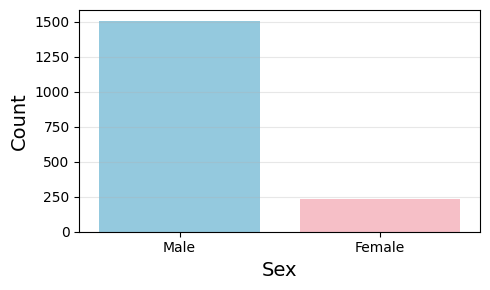

In [57]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.grid(alpha=0.3)
sns.countplot(data=halfmarathon_df, x="sex", ax=ax, palette={'M': 'skyblue', 'F': 'lightpink'},hue='sex',legend=False)
ax.set_xlabel('Sex', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticklabels(['Male', 'Female'])
fig.tight_layout()
fig.savefig('figs/halfmarathon_sex_countplot.pdf', dpi=300)

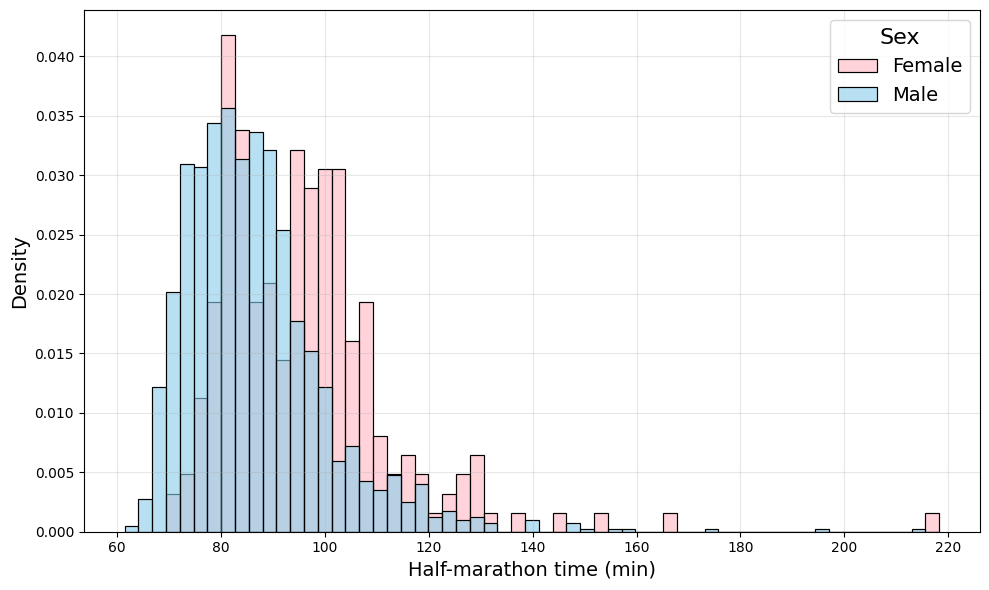

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(alpha=0.3)
sns.histplot(data=halfmarathon_df, x="time", ax=ax, hue='sex', stat="density",
             palette={'M': 'skyblue', 'F': 'lightpink'},
             common_norm=False, alpha=0.6)  # This ensures density is calculated separately for each group
ax.set_xlabel('Half-marathon time (min)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
plt.legend(title='Sex', labels=['Female', 'Male'], fontsize=14, title_fontsize=16)
fig.tight_layout()
fig.savefig('figs/halfmarathon_time.pdf', dpi=300)

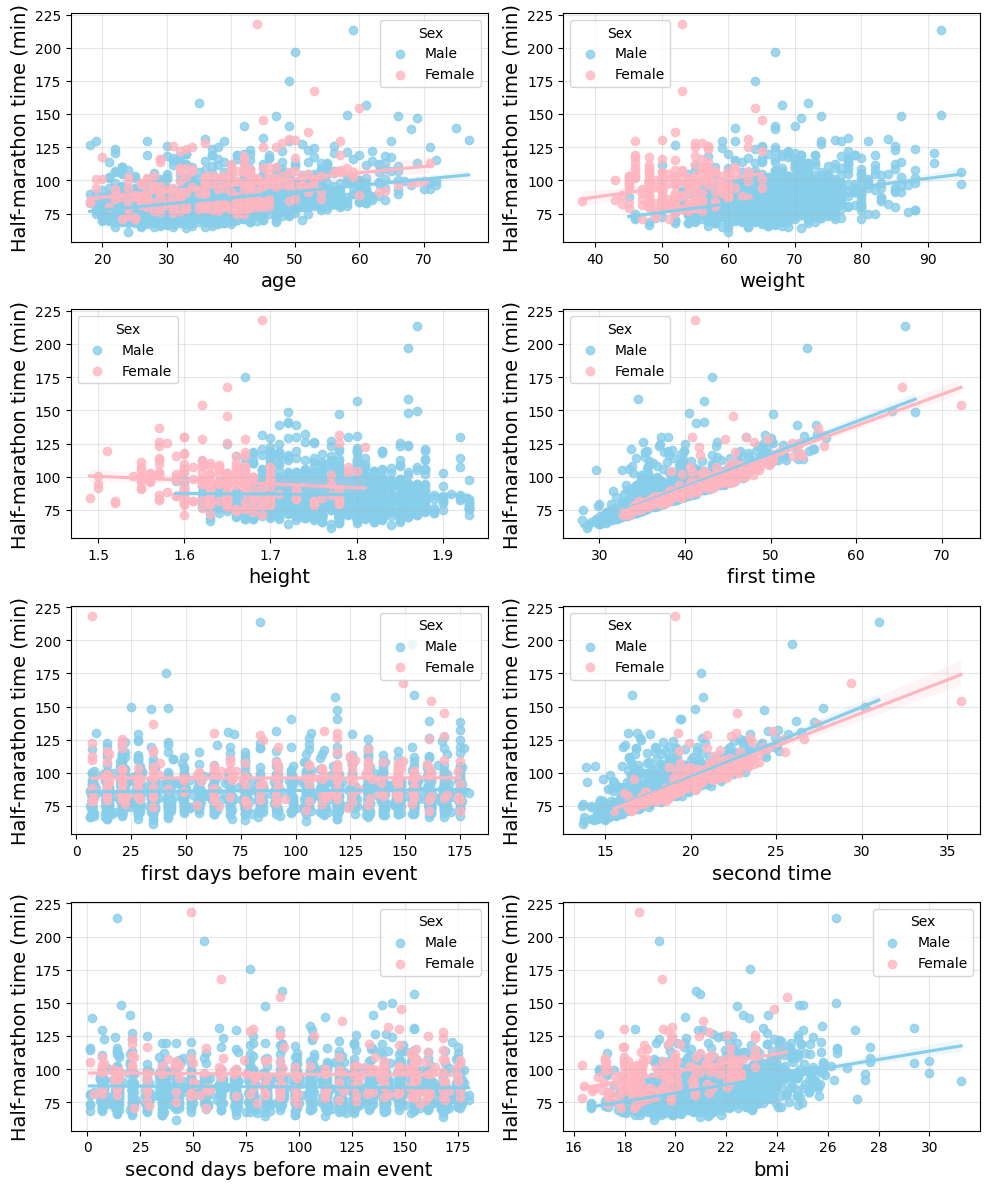

In [59]:
# Create a figure with 2 columns and multiple rows based on number of features
features = ['age', 'weight', 'height', 'bmi', 'first_time', 'first days before main event',
           'second_time', 'second days before main event']
features = halfmarathon_df.drop(['time','sex'],axis=1).columns
n_features = len(features)
n_cols = 2
n_rows = (n_features + 1) // 2  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3*n_rows))
axes = axes.flatten()

# Plot each feature vs time
for idx, feature in enumerate(features):
    # Create scatter plot with regression line for each sex
    sns.regplot(data=halfmarathon_df[halfmarathon_df['sex']=='M'],
                x=feature, y='time', scatter=True,
                color='skyblue', ax=axes[idx], label='Male')
    sns.regplot(data=halfmarathon_df[halfmarathon_df['sex']=='F'],
                x=feature, y='time', scatter=True,
                color='lightpink', ax=axes[idx], label='Female')

    axes[idx].set_xlabel(feature, fontsize=14)
    axes[idx].set_ylabel('Half-marathon time (min)', fontsize=14)
    axes[idx].grid(alpha=0.3)

    # Create a single legend for both plots
    handles, labels = axes[idx].get_legend_handles_labels()
    axes[idx].legend(handles[:2], ['Male', 'Female'], title='Sex')

# Remove any empty subplots
for idx in range(len(features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('figs/halfmarathon_feature_analysis.pdf', dpi=300)



C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\4224136272.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  correlation_matrix = halfmarathon_df.replace(['M','F'],[0,1]).corr()


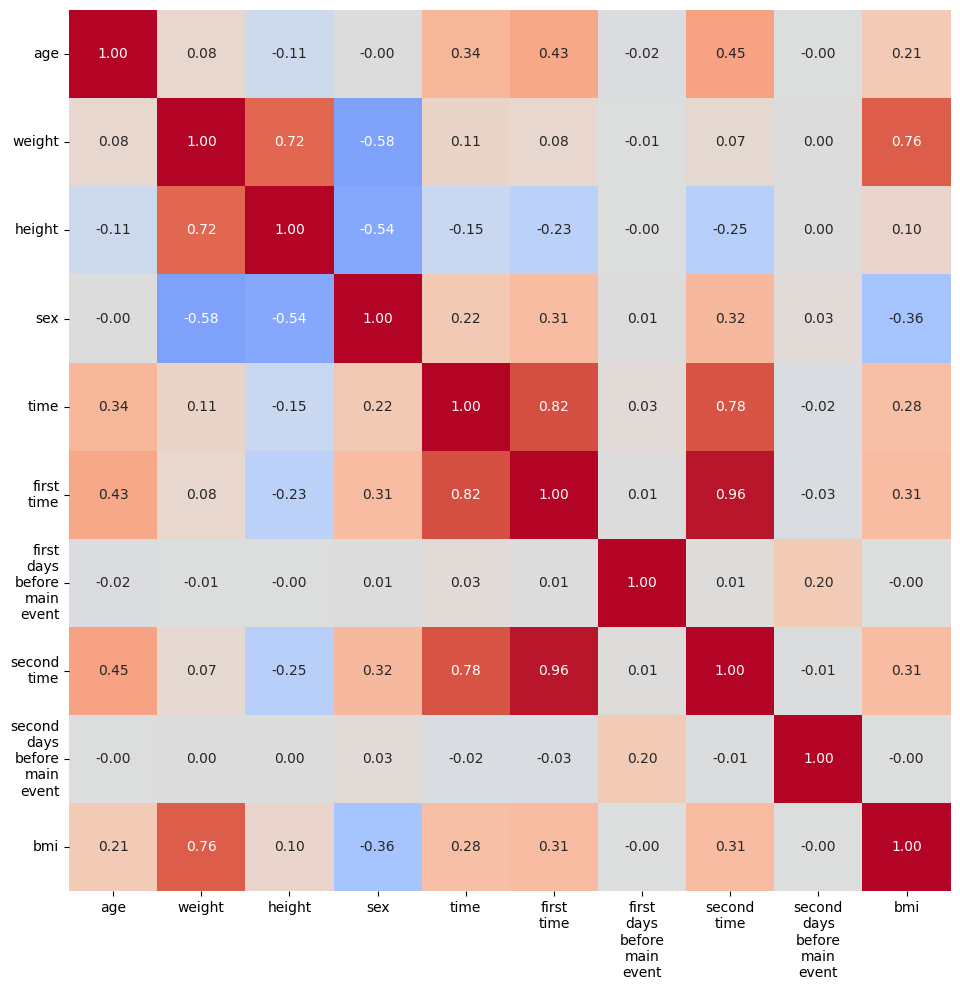

In [60]:
# Create correlation matrix
correlation_matrix = halfmarathon_df.replace(['M','F'],[0,1]).corr()

# Create figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix,
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make the plot square
            cbar=False)  #
# Split x-axis labels into multiple lines
x_labels = [label.replace(' ', '\n') for label in correlation_matrix.columns]
plt.xticks(np.array(range(len(x_labels))) + 0.5, x_labels, rotation=0)

# Split y-axis labels into multiple lines
y_labels = [label.replace(' ', '\n') for label in correlation_matrix.index]
plt.yticks(np.array(range(len(y_labels))) + 0.5, y_labels, rotation=0)


# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig('figs/halfmarathon_correlation.pdf', dpi=300, bbox_inches='tight')

In [61]:
halfmarathon_df.groupby('sex').agg('quantile',[0.25,0.75])


age  weight  height        time  first time  \
sex                                                      
F   0.25  31.0    48.0    1.60   84.137500   37.612500   
    0.75  45.0    56.0    1.67  103.075000   45.583333   
M   0.25  31.0    62.0    1.72   77.150000   34.316667   
    0.75  47.0    71.0    1.80   92.683333   40.033333   

          first days before main event  second time  \
sex                                                   
F   0.25                         35.00    18.175000   
    0.75                        134.75    21.695833   
M   0.25                         35.00    16.550000   
    0.75                        140.00    19.183333   

          second days before main event        bmi  
sex                                                 
F   0.25                          56.25  18.339100  
    0.75                         153.00  20.158206  
M   0.25                          51.00  20.281233  
    0.75                         141.00  22.530612

## Whole

In [62]:
df.describe()

age       weight       height     distance         time  \
count  6020.000000  6020.000000  6020.000000  6020.000000  6020.000000   
mean     40.994518    65.256146     1.747322    36.083033   163.056343   
std       9.896749     8.376791     0.074114     9.571118    56.613065   
min      18.000000    37.000000     1.490000    21.097500    61.466667   
25%      34.000000    60.000000     1.700000    21.097500   101.266667   
50%      41.000000    65.000000     1.750000    42.195000   174.425000   
75%      48.000000    70.000000     1.800000    42.195000   200.020833   
max      77.000000   104.000000     2.020000    42.195000   501.783333   

       first distance   first time  first days before main event  \
count     6020.000000  6020.000000                   6020.000000   
mean        17.882543    72.219012                     68.085714   
std          5.034506    23.806068                     50.322574   
min         10.000000    27.983333                      2.000000   
25%         10.000000    43.487500                     28.000000   
50%         21.097500    79.716667                     43.000000   
75%         21.097500    88.883333                    106.000000   
max         21.097500   213.750000                    180.000000   

       second distance  second time  second days before main event  \
count      6020.000000  6020.000000                    6020.000000   
mean          8.551495    32.565659                      93.672093   
std           2.268306     9.942348                      51.945386   
min           5.000000    13.666667                       1.000000   
25%           5.000000    20.633333                      49.000000   
50%          10.000000    35.800000                      92.000000   
75%          10.000000    39.533333                     140.000000   
max          10.000000    65.850000                     180.000000   

               bmi  
count  6020.000000  
mean     21.315326  
std       1.914715  
min      16.014543  
25%      20.047446  
50%      21.258503  
75%      22.448015  
max      35.111111

C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\758171556.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Male', 'Female'])


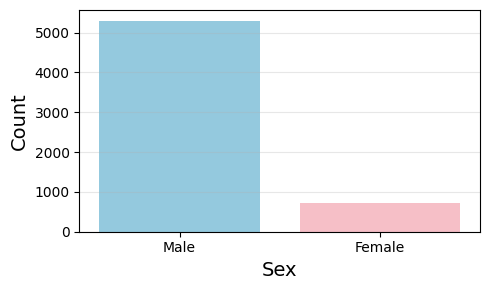

In [63]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.grid(alpha=0.3)
sns.countplot(data=df, x="sex", ax=ax, palette={'M': 'skyblue', 'F': 'lightpink'},hue='sex',legend=False)
ax.set_xlabel('Sex', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticklabels(['Male', 'Female'])
fig.tight_layout()
fig.savefig('figs/combaine_sex_countplot.pdf', dpi=300)

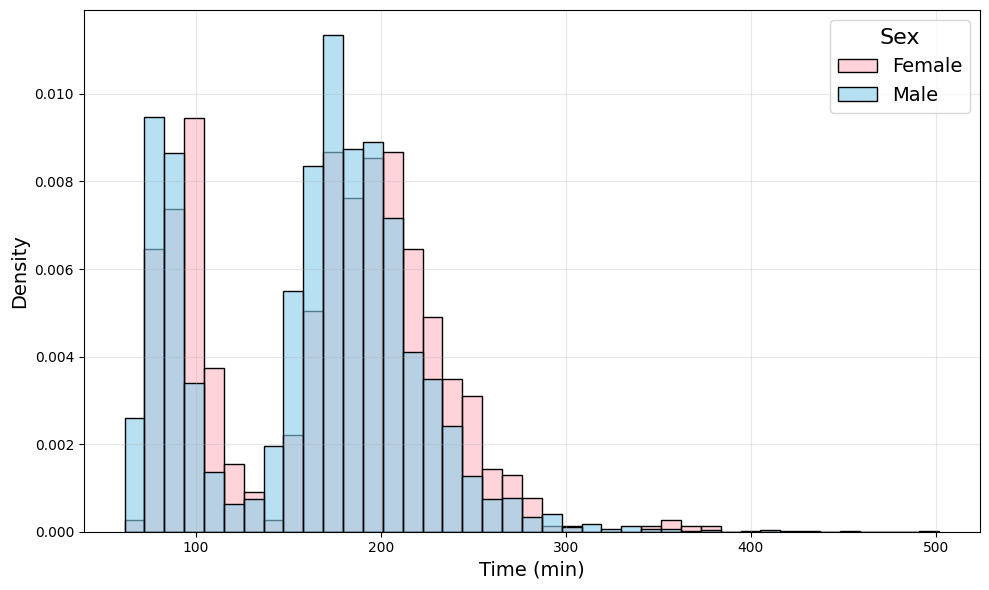

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(alpha=0.3)
sns.histplot(data=df, x="time", ax=ax, hue='sex', stat="density",
             palette={'M': 'skyblue', 'F': 'lightpink'},
             common_norm=False, alpha=0.6)  # This ensures density is calculated separately for each group
ax.set_xlabel('Time (min)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
plt.legend(title='Sex', labels=['Female', 'Male'], fontsize=14, title_fontsize=16)
fig.tight_layout()
fig.savefig('figs/combaine_time.pdf', dpi=300)

In [65]:
df.columns

Index(['age', 'weight', 'height', 'sex', 'distance', 'time', 'first distance',
       'first time', 'first days before main event', 'second distance',
       'second time', 'second days before main event', 'bmi'],
      dtype='object')

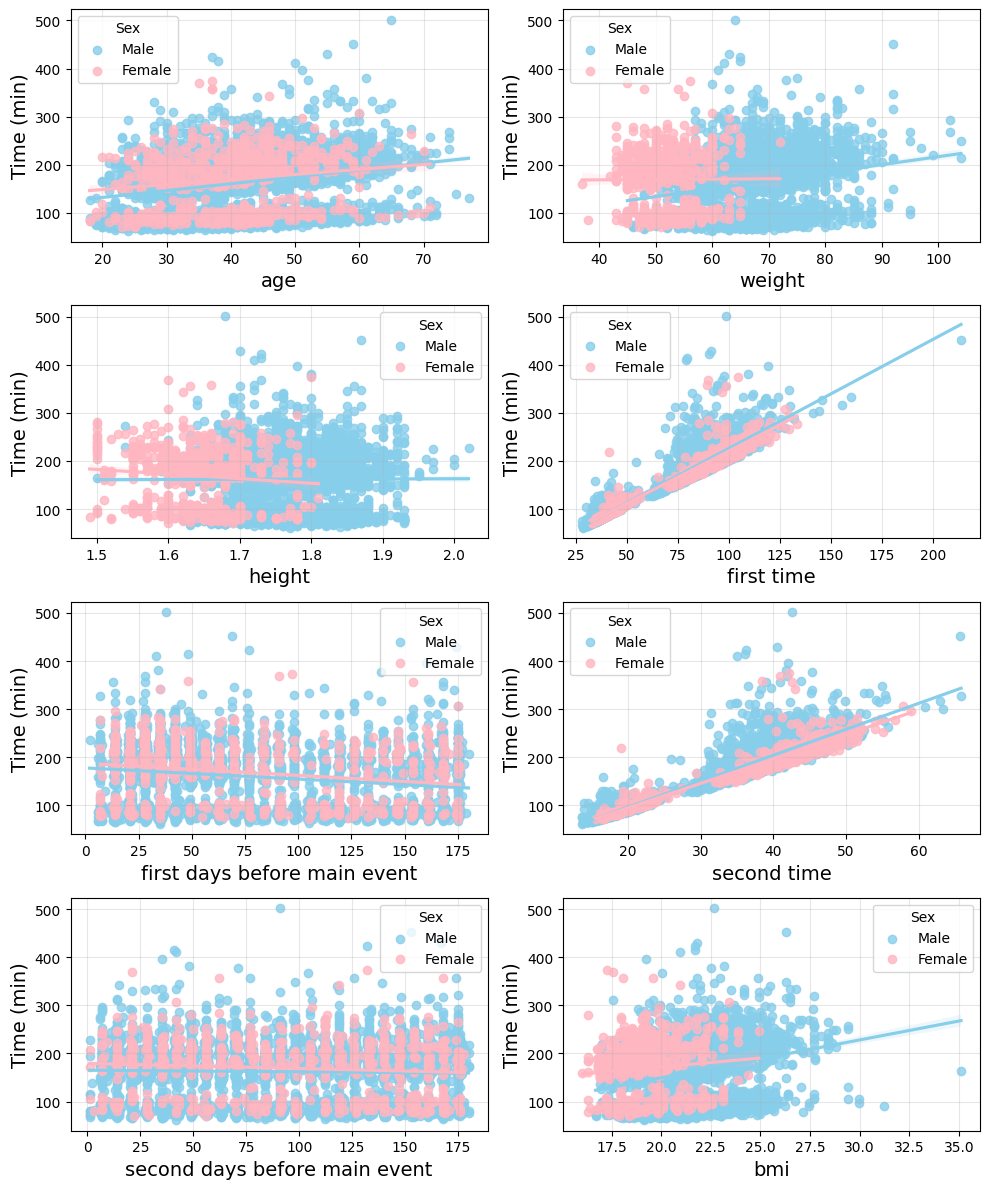

In [66]:
features = df.drop(['time','sex','distance','first distance','second distance'],axis=1).columns
n_features = len(features)
n_cols = 2
n_rows = (n_features + 1) // 2  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3*n_rows))
axes = axes.flatten()

# Plot each feature vs time
for idx, feature in enumerate(features):
    # Create scatter plot with regression line for each sex
    sns.regplot(data=df[df['sex']=='M'],
                x=feature, y='time', scatter=True,
                color='skyblue', ax=axes[idx], label='Male')
    sns.regplot(data=df[df['sex']=='F'],
                x=feature, y='time', scatter=True,
                color='lightpink', ax=axes[idx], label='Female')

    axes[idx].set_xlabel(feature, fontsize=14)
    axes[idx].set_ylabel('Time (min)', fontsize=14)
    axes[idx].grid(alpha=0.3)

    # Create a single legend for both plots
    handles, labels = axes[idx].get_legend_handles_labels()
    axes[idx].legend(handles[:2], ['Male', 'Female'], title='Sex')

# Remove any empty subplots
for idx in range(len(features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('figs/combaine_feature_analysis.pdf', dpi=300)



C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\1868621190.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  correlation_matrix = df.replace(['M','F'],[0,1]).corr()


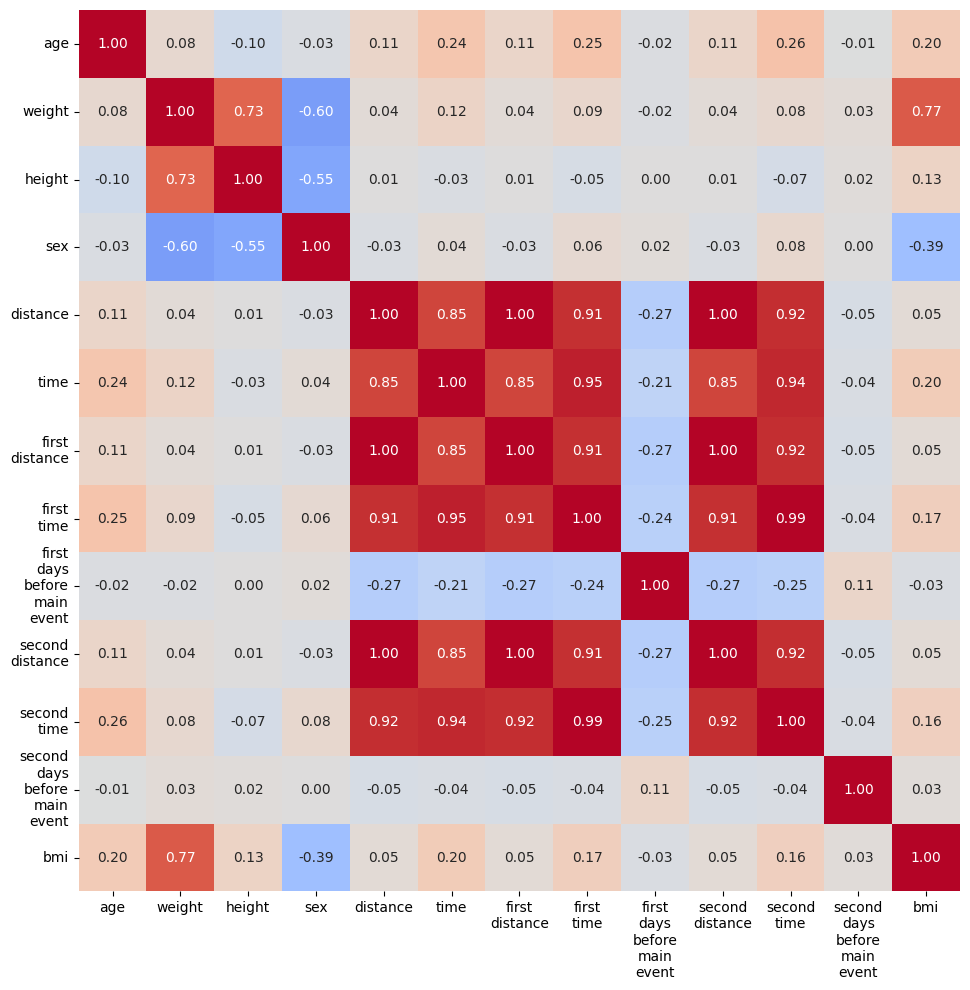

In [67]:
# Create correlation matrix
correlation_matrix = df.replace(['M','F'],[0,1]).corr()

# Create figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix,
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make the plot square
            cbar=False)  # Remove colorbar

# Split x-axis labels into multiple lines
x_labels = [label.replace(' ', '\n') for label in correlation_matrix.columns]
plt.xticks(np.array(range(len(x_labels))) + 0.5, x_labels, rotation=0)

# Split y-axis labels into multiple lines
y_labels = [label.replace(' ', '\n') for label in correlation_matrix.index]
plt.yticks(np.array(range(len(y_labels))) + 0.5, y_labels, rotation=0)
# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig('figs/combaine_correlation.pdf', dpi=300, bbox_inches='tight')

# Split data

In [68]:
X, y = df.drop('time',axis=1), df['time']
X_train_whole, X_test_whole, y_train_whole, y_test_whole = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['first distance']
)

X, y = marathon_df.drop('time',axis=1), marathon_df['time']
X_train_marathon, X_test_marathon, y_train_marathon, y_test_marathon = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X, y = halfmarathon_df.drop('time',axis=1), halfmarathon_df['time']
X_train_halfmarathon, X_test_halfmarathon, y_train_halfmarathon, y_test_halfmarathon = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Helpers

## Metrics

In [69]:


def custom_penalised_rmse(y_true, y_pred):
    # Ensure shapes are 1D
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    residual = y_pred - y_true
    # Penalize over-predictions more heavily
    mse = np.mean(np.where(residual > 0,
                            residual**2,
                            2 * residual**2))
    return np.sqrt(mse)

# wrap into a scorer (higher is better by default)
penalised_rmse = make_scorer(custom_penalised_rmse, greater_is_better=False)

## Prepocessor

In [70]:
numeric_cols = X_train_whole.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if 'days before' not in col and col not in ['height', 'weight']]
cat_cols     = X_train_whole.select_dtypes(include=['object','category']).columns.tolist()
preprocessor_whole = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'), cat_cols)
])


numeric_cols = X_train_marathon.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if 'days before' not in col and col not in ['height', 'weight']]
cat_cols     = X_train_marathon.select_dtypes(include=['object','category']).columns.tolist()
preprocessor_marathon = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'), cat_cols)
])


numeric_cols = X_train_halfmarathon.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if 'days before' not in col and col not in ['height', 'weight']]
cat_cols     = X_train_halfmarathon.select_dtypes(include=['object','category']).columns.tolist()
preprocessor_halfmarathon = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore',drop='first'), cat_cols)
])

# Models

## Helpers

In [71]:
def create_best_pipelines(model, params_grid, scoring=penalised_rmse, path='models', overwrite=False):
    # Create parameter dictionary with proper model prefix
    params = {}
    for key, items in params_grid.items():
        params[f"model__{key}"] = items

    # Create pipelines for each dataset
    pipes = {
        "whole": Pipeline([("preproc", preprocessor_whole), ("model", model())]),
        "marathon": Pipeline([("preproc", preprocessor_marathon), ("model", model())]),
        "halfmarathon": Pipeline([("preproc", preprocessor_halfmarathon), ("model", model())]),
    }

    # Train and save models for each dataset
    for dataset in ["whole", "marathon", "halfmarathon"]:
        os.makedirs(f'{path}/best_pipeline/', exist_ok=True)
        best_model_path = f'{path}/best_pipeline/{model.__name__}_{dataset}.joblib'
        os.makedirs(f'{path}/grid_search/',exist_ok=True)
        grid_path = f'{path}/grid_search/{model.__name__}_{dataset}.joblib'
        os.makedirs(f'{path}/cv_results/',exist_ok=True)
        cv_results_path = f'{path}/cv_results/{model.__name__}_{dataset}.csv'

        if overwrite or not ( os.path.exists(best_model_path) and os.path.exists(cv_results_path)) :
            # Create and configure GridSearchCV
            grid = GridSearchCV(
                estimator=pipes[dataset],
                param_grid=params,
                scoring=scoring,
                cv=5,
                n_jobs=1,
                verbose=3,
                return_train_score=True,
                refit=True,
            )


            # Get training data
            X_train = eval(f"X_train_{dataset}")
            y_train = eval(f"y_train_{dataset}")

            # Train model
            print(f"Training {model.__name__} for {dataset} dataset...")
            grid.fit(X_train, y_train)

            # Save the entire GridSearchCV object for reproducibility
            joblib.dump(grid, grid_path)

            # Save best model
            joblib.dump(grid.best_estimator_, best_model_path)

            df = pd.DataFrame(grid.cv_results_)
            # Convert negative scores to positive
            score_columns = [col for col in df.columns if 'score' in col and 'time' not in col]
            df[score_columns] = df[score_columns].abs()  # Convert negative scores to positive

            # Reorder columns to put mean_train_score and std_train_score first
            first_columns = ['params','mean_test_score','std_test_score']
            remaining_score_columns = [col for col in score_columns if col not in first_columns]
            df = df.drop_duplicates(subset=remaining_score_columns)
            other_columns = [col for col in df.columns if col not in score_columns]
            df = df[first_columns + remaining_score_columns + other_columns]

            # Sort by mean_train_score
            df = df.sort_values('mean_test_score')

            df.to_csv(cv_results_path, header=True, index=False)


            print(f"\nResults for {model.__name__} ({dataset}):")
            print("Best parameters:", grid.best_params_)
            print("Best score:", -grid.best_score_)


        df =pd.read_csv(cv_results_path)
        print(f"Cross validation result for {dataset} dataset:")
        display(df)
        print("\n" + "="*50)

def create_best_pipelines_keras(
    build_fn,
    params_grid,
    scoring,
    path='models',
    overwrite=False,
    datasets=None,
    epochs = 10
):
  # Extract only hyperparameters that belong to the Keras build_fn:
    model_params = {k: v for k, v in params_grid.items() if k not in ['epochs','batch_size']}
    # Pull out grid values for training-time params:
    train_params = {'epochs': [epochs], 'batch_size': params_grid['batch_size']}
    if datasets is None:
        datasets = {
            'whole': (preprocessor_whole, X_train_whole, y_train_whole, None),
            'marathon': (preprocessor_marathon, X_train_marathon, y_train_marathon, None),
            'halfmarathon': (preprocessor_halfmarathon,X_train_halfmarathon,y_train_halfmarathon, None)
        }

    for name, (preproc, X_var, y_var, input_shape) in datasets.items():
        X_train = X_var
        y_train = y_var

        # Wrapper args now only contain scalars:
        wrapper_args = {'callbacks': [TerminateOnNaN(), EarlyStopping(patience=3,monitor='loss')  ]}
        if input_shape:
            wrapper_args['input_shape'] = input_shape
        else:
            wrapper_args['input_dim'] = preproc.fit_transform(X_train).shape[1]

        # Build the full param_grid for GridSearchCV:
        grid_params = {
            **{f"model__model__{k}": v for k, v in model_params.items()},
            **{f"model__{k}": v for k, v in train_params.items()}
        }

        model_wrapper = KerasRegressor(model=build_fn, **wrapper_args, verbose=0)
        pipe = Pipeline([('preproc', preproc), ('model', model_wrapper)])


        os.makedirs(f"{path}/best_pipeline", exist_ok=True)
        os.makedirs(f"{path}/grid_search", exist_ok=True)
        os.makedirs(f"{path}/cv_results", exist_ok=True)

        best_path = f"{path}/best_pipeline/{build_fn.__name__}_{name}.joblib"
        grid_path = f"{path}/grid_search/{build_fn.__name__}_{name}.joblib"
        results_path = f"{path}/cv_results/{build_fn.__name__}_{name}.csv"

        if overwrite or not os.path.exists(best_path):
            grid = GridSearchCV(
                estimator=pipe,
                param_grid=grid_params,
                scoring=scoring,
                cv=5,
                n_jobs=1,
                verbose=0,
                return_train_score=True,
                refit=True,
                error_score='raise'
            )

            grid.fit(X_train, y_train)
            joblib.dump(grid, grid_path)
            joblib.dump(grid.best_estimator_, best_path)

            df = pd.DataFrame(grid.cv_results_)
            score_cols = [c for c in df.columns if 'score' in c]
            df[score_cols] = df[score_cols].abs()
            first = ['params', 'mean_test_score', 'std_test_score']
            rest = [c for c in score_cols if c not in first]
            df = df[first + rest + [c for c in df.columns if c not in score_cols]]
            df = df.sort_values('mean_test_score')
            df.to_csv(results_path, index=False)
            print(f"Best params for '{name}': {grid.best_params_}")

        df = pd.read_csv(results_path)
        print(f"CV results for '{name}':")
        display(df)


<strong zostawić też te gorsze ??? >


## Riegel

$T = T_1 \left(\frac{D}{D_1}\right)^k $

In [72]:
def riegel(distance: float,  shorter_distance: float, shorter_time:float , k:float = 1.07):
    return shorter_time*np.power(distance/shorter_distance, k)

## Linear models

### Linear regresion

In [73]:
create_best_pipelines(model=LinearRegression,params_grid={},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0     {}         24.76645        1.653149          26.198638   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          23.005041          24.837216          22.837478          26.953878   

   rank_test_score  split0_train_score  ...  split2_train_score  \
0                1           24.436022  ...            24.73796   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  \
0           25.238918           24.254396         24.779252         0.402125   

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  params.1  
0       0.004972       0.00122         0.002626        0.000512        {}  

[1 rows x 21 columns]


Cross validation result for marathon dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0     {}        27.219927        4.263129          23.602886   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          28.840362          25.163596          34.846435          23.646356   

   rank_test_score  split0_train_score  ...  split2_train_score  \
0                1           28.355131  ...           28.090412   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  \
0           25.409866           28.396181         27.495498          1.12487   

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  params.1  
0       0.004478      0.000489         0.001644        0.000523        {}  

[1 rows x 21 columns]


Cross validation result for halfmarathon dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0     {}        10.428005        2.205907          14.608881   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          10.001657           8.113129          10.078089           9.338268   

   rank_test_score  split0_train_score  ...  split2_train_score  \
0                1            9.436868  ...           11.069544   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  \
0            10.71871            10.84814         10.558822          0.57535   

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  params.1  
0       0.004113      0.001491           0.0016         0.00049        {}  

[1 rows x 21 columns]

### Ridge Regression

In [74]:
create_best_pipelines(model=Ridge,params_grid={'alpha':[0.05,0.1,0.2,1,10]},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0  {'model__alpha': 0.05}        24.774568        1.654100          26.199103   
1   {'model__alpha': 0.1}        24.774717        1.654120          26.199567   
2   {'model__alpha': 0.2}        24.775017        1.654160          26.200494   
3     {'model__alpha': 1}        24.777515        1.654473          26.207865   
4    {'model__alpha': 10}        24.812989        1.657232          26.284614   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          23.025334          24.835592          22.838481          26.974332   
1          23.025249          24.835339          22.838961          26.974469   
2          23.025084          24.834836          22.839922          26.974746   
3          23.024034          24.831034          22.847545          26.977096   
4          23.034391          24.806869          22.925770          27.013299   

   rank_test_score  split0_train_score  ...  split3_train_score  \
0                1           24.436167  ...           25.248915   
1                2           24.436313  ...           25.249059   
2                3           24.436608  ...           25.249348   
3                4           24.439048  ...           25.251737   
4                5           24.472637  ...           25.283842   

   split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0           24.266776         24.789374         0.404304       0.004642   
1           24.266944         24.789540         0.404305       0.004199   
2           24.267283         24.789875         0.404307       0.004203   
3           24.270094         24.792644         0.404319       0.005949   
4           24.308927         24.830382         0.404214       0.005099   

   std_fit_time  mean_score_time  std_score_time  param_model__alpha  \
0      0.000387         0.001602        0.000491                0.05   
1      0.000401         0.001801        0.000401                0.10   
2      0.000752         0.001814        0.000407                0.20   
3      0.001704         0.001705        0.000389                1.00   
4      0.001023         0.001703        0.000399               10.00   

                 params.1  
0  {'model__alpha': 0.05}  
1   {'model__alpha': 0.1}  
2   {'model__alpha': 0.2}  
3     {'model__alpha': 1}  
4    {'model__alpha': 10}  

[5 rows x 22 columns]


Cross validation result for marathon dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0  {'model__alpha': 0.05}        27.219960        4.263148          23.602845   
1   {'model__alpha': 0.1}        27.219992        4.263167          23.602804   
2   {'model__alpha': 0.2}        27.220058        4.263206          23.602724   
3     {'model__alpha': 1}        27.220590        4.263511          23.602093   
4    {'model__alpha': 10}        27.227374        4.266606          23.596693   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          28.840419          25.163555          34.846503          23.646476   
1          28.840476          25.163514          34.846571          23.646597   
2          28.840590          25.163432          34.846706          23.646837   
3          28.841514          25.162789          34.847792          23.648764   
4          28.852806          25.157016          34.859999          23.670354   

   rank_test_score  split0_train_score  ...  split3_train_score  \
0                1           28.355177  ...           25.409901   
1                2           28.355223  ...           25.409936   
2                3           28.355315  ...           25.410006   
3                4           28.356058  ...           25.410574   
4                5           28.365092  ...           25.417700   

   split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0           28.396213         27.495537         1.124873       0.004486   
1           28.396246         27.495576         1.124875       0.004068   
2           28.396310         27.495655         1.124879       0.004474   
3           28.396833         27.496291         1.124913       0.003612   
4           28.403295         27.504121         1.125259       0.004387   

   std_fit_time  mean_score_time  std_score_time  param_model__alpha  \
0      0.000502         0.002075        0.000285                0.05   
1      0.000852         0.002140        0.000327                0.10   
2      0.001342         0.002300        0.001115                0.20   
3      0.000476         0.001800        0.000747                1.00   
4      0.000805         0.001804        0.000753               10.00   

                 params.1  
0  {'model__alpha': 0.05}  
1   {'model__alpha': 0.1}  
2   {'model__alpha': 0.2}  
3     {'model__alpha': 1}  
4    {'model__alpha': 10}  

[5 rows x 22 columns]


Cross validation result for halfmarathon dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0  {'model__alpha': 0.05}        10.428023        2.205988          14.609010   
1   {'model__alpha': 0.1}        10.428042        2.206068          14.609139   
2   {'model__alpha': 0.2}        10.428082        2.206230          14.609398   
3     {'model__alpha': 1}        10.428461        2.207493          14.611499   
4    {'model__alpha': 10}        10.438205        2.219277          14.637395   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          10.001712           8.112897          10.078083           9.338416   
1          10.001766           8.112666          10.078077           9.338564   
2          10.001876           8.112208          10.078067           9.338860   
3          10.002754           8.108685          10.078099           9.341268   
4          10.012375           8.082341          10.087707           9.371207   

   rank_test_score  split0_train_score  ...  split3_train_score  \
0                1            9.436927  ...           10.718777   
1                2            9.436986  ...           10.718844   
2                3            9.437106  ...           10.718979   
3                4            9.438109  ...           10.720105   
4                5            9.453363  ...           10.736428   

   split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0           10.848205         10.558886         0.575354       0.003458   
1           10.848270         10.558950         0.575357       0.002994   
2           10.848401         10.559081         0.575365       0.009400   
3           10.849490         10.560169         0.575423       0.003999   
4           10.865013         10.576283         0.576108       0.003186   

   std_fit_time  mean_score_time  std_score_time  param_model__alpha  \
0      0.000460         0.001355        0.000419                0.05   
1      0.000023         0.002000        0.000005                0.10   
2      0.004588         0.003205        0.000747                0.20   
3      0.000891         0.002220        0.001457                1.00   
4      0.000411         0.001000        0.000004               10.00   

                 params.1  
0  {'model__alpha': 0.05}  
1   {'model__alpha': 0.1}  
2   {'model__alpha': 0.2}  
3     {'model__alpha': 1}  
4    {'model__alpha': 10}  

[5 rows x 22 columns]

### Lasso Regression

In [75]:
create_best_pipelines(model=Lasso,params_grid={'alpha':[0.05,0.1,0.2,1,10]},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0  {'model__alpha': 0.05}        24.786800        1.658646          26.198313   
1   {'model__alpha': 0.1}        24.809058        1.662829          26.207122   
2   {'model__alpha': 0.2}        24.865638        1.665561          26.249111   
3     {'model__alpha': 1}        25.018244        1.681525          26.441551   
4    {'model__alpha': 10}        28.168113        1.742186          29.671396   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          23.059110          24.844665          22.825319          27.006595   
1          23.103755          24.862082          22.823437          27.048891   
2          23.201489          24.902377          22.847983          27.127230   
3          23.441577          24.959006          22.933670          27.315414   
4          27.230423          27.325275          25.931012          30.682460   

   rank_test_score  split0_train_score  ...  split3_train_score  \
0                1           24.449379  ...           25.261545   
1                2           24.472665  ...           25.283635   
2                3           24.542240  ...           25.347904   
3                4           24.707515  ...           25.517191   
4                5           27.882834  ...           28.656694   

   split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0           24.278304         24.801663         0.404374       0.014837   
1           24.300419         24.824157         0.404234       0.010177   
2           24.354579         24.883938         0.404219       0.007745   
3           24.513085         25.046263         0.402578       0.004557   
4           27.716576         28.204709         0.365830       0.005562   

   std_fit_time  mean_score_time  std_score_time  param_model__alpha  \
0      0.000710         0.002576        0.000523                0.05   
1      0.000970         0.001964        0.000634                0.10   
2      0.001163         0.002456        0.000781                0.20   
3      0.001152         0.001599        0.000491                1.00   
4      0.001405         0.002199        0.000747               10.00   

                 params.1  
0  {'model__alpha': 0.05}  
1   {'model__alpha': 0.1}  
2   {'model__alpha': 0.2}  
3     {'model__alpha': 1}  
4    {'model__alpha': 10}  

[5 rows x 22 columns]


Cross validation result for marathon dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0  {'model__alpha': 0.05}        27.225702        4.264946          23.607245   
1   {'model__alpha': 0.1}        27.234373        4.266480          23.614053   
2   {'model__alpha': 0.2}        27.259834        4.268551          23.635662   
3     {'model__alpha': 1}        27.397653        4.253655          23.752942   
4    {'model__alpha': 10}        30.274873        3.914980          26.527837   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          28.861832          25.155675          34.850221          23.653535   
1          28.886015          25.151144          34.856343          23.664309   
2          28.941997          25.152326          34.874649          23.694535   
3          29.125658          25.245430          34.967811          23.896423   
4          31.851374          28.366309          37.220927          27.407918   

   rank_test_score  split0_train_score  ...  split3_train_score  \
0                1           28.361475  ...           25.416727   
1                2           28.370515  ...           25.426600   
2                3           28.395983  ...           25.454798   
3                4           28.526233  ...           25.618353   
4                5           31.262697  ...           28.652248   

   split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0           28.401513         27.501570         1.124667       0.004952   
1           28.409566         27.510464         1.124360       0.004583   
2           28.433354         27.536101         1.123434       0.004228   
3           28.573604         27.680076         1.116873       0.004398   
4           31.284943         30.496571         1.000452       0.004198   

   std_fit_time  mean_score_time  std_score_time  param_model__alpha  \
0      0.001108         0.002530        0.000977                0.05   
1      0.000814         0.002402        0.000487                0.10   
2      0.000779         0.001777        0.000744                0.20   
3      0.000489         0.001801        0.000401                1.00   
4      0.000749         0.001605        0.000490               10.00   

                 params.1  
0  {'model__alpha': 0.05}  
1   {'model__alpha': 0.1}  
2   {'model__alpha': 0.2}  
3     {'model__alpha': 1}  
4    {'model__alpha': 10}  

[5 rows x 22 columns]


Cross validation result for halfmarathon dataset:


params  mean_test_score  std_test_score  split0_test_score  \
0  {'model__alpha': 0.05}        10.438463        2.215847          14.635247   
1   {'model__alpha': 0.1}        10.455439        2.225791          14.667807   
2   {'model__alpha': 0.2}        10.475546        2.231303          14.688006   
3     {'model__alpha': 1}        10.570421        2.298844          14.875674   
4    {'model__alpha': 10}        16.490789        2.588647          20.429083   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           9.984011           8.107667          10.120987           9.344405   
1           9.972012           8.108045          10.169875           9.359453   
2           9.962107           8.100952          10.243088           9.383577   
3           9.914789           8.055502          10.497930           9.508212   
4          14.548239          12.978109          17.854381          16.644135   

   rank_test_score  split0_train_score  ...  split3_train_score  \
0                1            9.447815  ...           10.728561   
1                2            9.465973  ...           10.744455   
2                3            9.484739  ...           10.770245   
3                4            9.637951  ...           10.872411   
4                5           15.889975  ...           16.658200   

   split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0           10.860584         10.570650         0.575884       0.003399   
1           10.879527         10.588793         0.575966       0.003571   
2           10.909480         10.619416         0.582046       0.003600   
3           11.035378         10.749552         0.572907       0.003180   
4           16.812424         16.627363         0.385356       0.003807   

   std_fit_time  mean_score_time  std_score_time  param_model__alpha  \
0      0.000489         0.001406        0.000798                0.05   
1      0.000785         0.001445        0.000460                0.10   
2      0.000800         0.001400        0.000490                0.20   
3      0.000511         0.001556        0.000427                1.00   
4      0.000742         0.001992        0.000621               10.00   

                 params.1  
0  {'model__alpha': 0.05}  
1   {'model__alpha': 0.1}  
2   {'model__alpha': 0.2}  
3     {'model__alpha': 1}  
4    {'model__alpha': 10}  

[5 rows x 22 columns]

### Elastic Net

In [76]:
create_best_pipelines(model=ElasticNet,params_grid={'alpha':[0.05,0.1,0.2,1,10], 'l1_ratio':[0.1,0.4,0.5,0.9,1]},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  \
0     {'model__alpha': 0.05, 'model__l1_ratio': 1}        24.786800   
1      {'model__alpha': 0.1, 'model__l1_ratio': 1}        24.809058   
2      {'model__alpha': 0.2, 'model__l1_ratio': 1}        24.865638   
3   {'model__alpha': 0.05, 'model__l1_ratio': 0.9}        24.872442   
4    {'model__alpha': 0.1, 'model__l1_ratio': 0.9}        24.993284   
5        {'model__alpha': 1, 'model__l1_ratio': 1}        25.018244   
6    {'model__alpha': 0.2, 'model__l1_ratio': 0.9}        25.170653   
7   {'model__alpha': 0.05, 'model__l1_ratio': 0.5}        25.178941   
8   {'model__alpha': 0.05, 'model__l1_ratio': 0.4}        25.235646   
9   {'model__alpha': 0.05, 'model__l1_ratio': 0.1}        25.432432   
10   {'model__alpha': 0.1, 'model__l1_ratio': 0.5}        25.495792   
11   {'model__alpha': 0.1, 'model__l1_ratio': 0.4}        25.624283   
12   {'model__alpha': 0.1, 'model__l1_ratio': 0.1}        25.993911   
13   {'model__alpha': 0.2, 'model__l1_ratio': 0.5}        26.108138   
14     {'model__alpha': 1, 'model__l1_ratio': 0.9}        26.194302   
15   {'model__alpha': 0.2, 'model__l1_ratio': 0.4}        26.330734   
16   {'model__alpha': 0.2, 'model__l1_ratio': 0.1}        26.918594   
17      {'model__alpha': 10, 'model__l1_ratio': 1}        28.168113   
18     {'model__alpha': 1, 'model__l1_ratio': 0.5}        29.230320   
19     {'model__alpha': 1, 'model__l1_ratio': 0.4}        29.723584   
20     {'model__alpha': 1, 'model__l1_ratio': 0.1}        31.016602   
21    {'model__alpha': 10, 'model__l1_ratio': 0.9}        36.435850   
22    {'model__alpha': 10, 'model__l1_ratio': 0.5}        46.494186   
23    {'model__alpha': 10, 'model__l1_ratio': 0.4}        47.896662   
24    {'model__alpha': 10, 'model__l1_ratio': 0.1}        50.969018   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         1.658646          26.198313          23.059110          24.844665   
1         1.662829          26.207122          23.103755          24.862082   
2         1.665561          26.249111          23.201489          24.902377   
3         1.661880          26.364708          23.103028          24.810485   
4         1.664332          26.512436          23.250548          24.847124   
5         1.681525          26.441551          23.441577          24.959006   
6         1.665855          26.721238          23.460758          24.924605   
7         1.660600          26.736489          23.472237          24.918633   
8         1.658266          26.796607          23.550508          24.945980   
9         1.654061          26.995625          23.822060          25.064244   
10        1.652717          27.063501          23.909648          25.101063   
11        1.651442          27.188544          24.084343          25.186971   
12        1.645751          27.548403          24.575909          25.447355   
13        1.646229          27.667627          24.725148          25.523096   
14        1.680118          27.834252          24.820693          25.511444   
15        1.644378          27.884165          25.012193          25.687330   
16        1.643587          28.459046          25.752853          26.131064   
17        1.742186          29.671396          27.230423          27.325275   
18        1.700632          30.798236          28.469645          27.921940   
19        1.714837          31.289546          29.030405          28.324460   
20        1.752150          32.577407          30.470246          29.405604   
21        1.892746          38.162607          36.064618          34.222151   
22        1.825910          47.881413          46.373316          44.024197   
23        1.808476          49.231940          47.793441          45.421668   
24        1.771779          52.203067          50.892997          48.489293   

    split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0           22.825319          27.006595                1    


Cross validation result for marathon dataset:


params  mean_test_score  \
0     {'model__alpha': 0.05, 'model__l1_ratio': 1}        27.225702   
1      {'model__alpha': 0.1, 'model__l1_ratio': 1}        27.234373   
2   {'model__alpha': 0.05, 'model__l1_ratio': 0.9}        27.236356   
3    {'model__alpha': 0.1, 'model__l1_ratio': 0.9}        27.258535   
4      {'model__alpha': 0.2, 'model__l1_ratio': 1}        27.259834   
5   {'model__alpha': 0.05, 'model__l1_ratio': 0.5}        27.293738   
6   {'model__alpha': 0.05, 'model__l1_ratio': 0.4}        27.309231   
7    {'model__alpha': 0.2, 'model__l1_ratio': 0.9}        27.313265   
8   {'model__alpha': 0.05, 'model__l1_ratio': 0.1}        27.355254   
9    {'model__alpha': 0.1, 'model__l1_ratio': 0.5}        27.381523   
10       {'model__alpha': 1, 'model__l1_ratio': 1}        27.397653   
11   {'model__alpha': 0.1, 'model__l1_ratio': 0.4}        27.411183   
12   {'model__alpha': 0.1, 'model__l1_ratio': 0.1}        27.495231   
13   {'model__alpha': 0.2, 'model__l1_ratio': 0.5}        27.548966   
14   {'model__alpha': 0.2, 'model__l1_ratio': 0.4}        27.601347   
15     {'model__alpha': 1, 'model__l1_ratio': 0.9}        27.703308   
16   {'model__alpha': 0.2, 'model__l1_ratio': 0.1}        27.751511   
17     {'model__alpha': 1, 'model__l1_ratio': 0.5}        28.752325   
18     {'model__alpha': 1, 'model__l1_ratio': 0.4}        29.025072   
19     {'model__alpha': 1, 'model__l1_ratio': 0.1}        29.814174   
20      {'model__alpha': 10, 'model__l1_ratio': 1}        30.274873   
21    {'model__alpha': 10, 'model__l1_ratio': 0.9}        33.838592   
22    {'model__alpha': 10, 'model__l1_ratio': 0.5}        38.097753   
23    {'model__alpha': 10, 'model__l1_ratio': 0.4}        38.496306   
24    {'model__alpha': 10, 'model__l1_ratio': 0.1}        39.269894   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         4.264946          23.607245          28.861832          25.155675   
1         4.266480          23.614053          28.886015          25.151144   
2         4.269046          23.599784          28.877092          25.149715   
3         4.273085          23.605353          28.918475          25.145616   
4         4.268551          23.635662          28.941997          25.152326   
5         4.276917          23.611442          28.954183          25.158124   
6         4.277539          23.619771          28.974179          25.164367   
7         4.277166          23.634386          29.008711          25.156795   
8         4.277590          23.650496          29.031858          25.187377   
9         4.277086          23.672034          29.073003          25.198173   
10        4.253655          23.752942          29.125658          25.245430   
11        4.275599          23.696289          29.108166          25.216798   
12        4.268867          23.772259          29.205063          25.275883   
13        4.264781          23.823646          29.282627          25.308348   
14        4.258821          23.875619          29.340685          25.350409   
15        4.246224          23.964690          29.466823          25.424339   
16        4.239218          24.031789          29.502799          25.479695   
17        4.104326          25.093745          30.542925          26.457203   
18        4.067280          25.394244          30.827598          26.732924   
19        3.968480          26.253767          31.648500          27.542392   
20        3.914980          26.527837          31.851374          28.366309   
21        3.595461          30.344837          35.743488          31.844089   
22        3.247050          34.915702          40.105901          36.331665   
23        3.218826          35.344386          40.517606          36.749136   
24        3.166283          36.173665          41.315821          37.559598   

    split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0           34.850221          23.653535                1    


Cross validation result for halfmarathon dataset:


params  mean_test_score  \
0     {'model__alpha': 0.05, 'model__l1_ratio': 1}        10.438463   
1   {'model__alpha': 0.05, 'model__l1_ratio': 0.9}        10.442010   
2      {'model__alpha': 0.1, 'model__l1_ratio': 1}        10.455439   
3    {'model__alpha': 0.1, 'model__l1_ratio': 0.9}        10.464567   
4   {'model__alpha': 0.05, 'model__l1_ratio': 0.5}        10.474962   
5      {'model__alpha': 0.2, 'model__l1_ratio': 1}        10.475546   
6   {'model__alpha': 0.05, 'model__l1_ratio': 0.4}        10.484118   
7    {'model__alpha': 0.2, 'model__l1_ratio': 0.9}        10.507056   
8   {'model__alpha': 0.05, 'model__l1_ratio': 0.1}        10.510522   
9    {'model__alpha': 0.1, 'model__l1_ratio': 0.5}        10.533720   
10   {'model__alpha': 0.1, 'model__l1_ratio': 0.4}        10.549455   
11       {'model__alpha': 1, 'model__l1_ratio': 1}        10.570421   
12   {'model__alpha': 0.1, 'model__l1_ratio': 0.1}        10.591460   
13   {'model__alpha': 0.2, 'model__l1_ratio': 0.5}        10.631703   
14   {'model__alpha': 0.2, 'model__l1_ratio': 0.4}        10.655655   
15   {'model__alpha': 0.2, 'model__l1_ratio': 0.1}        10.724085   
16     {'model__alpha': 1, 'model__l1_ratio': 0.9}        10.780966   
17     {'model__alpha': 1, 'model__l1_ratio': 0.5}        11.312397   
18     {'model__alpha': 1, 'model__l1_ratio': 0.4}        11.439578   
19     {'model__alpha': 1, 'model__l1_ratio': 0.1}        11.798038   
20      {'model__alpha': 10, 'model__l1_ratio': 1}        16.490789   
21    {'model__alpha': 10, 'model__l1_ratio': 0.1}        16.733478   
22    {'model__alpha': 10, 'model__l1_ratio': 0.9}        16.793600   
23    {'model__alpha': 10, 'model__l1_ratio': 0.5}        16.866971   
24    {'model__alpha': 10, 'model__l1_ratio': 0.4}        16.870800   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         2.215847          14.635247           9.984011           8.107667   
1         2.222368          14.647180           9.993465           8.087950   
2         2.225791          14.667807           9.972012           8.108045   
3         2.236351          14.689818           9.992043           8.075619   
4         2.239127          14.702416          10.022022           8.063983   
5         2.231303          14.688006           9.962107           8.100952   
6         2.242159          14.715913          10.026879           8.063796   
7         2.249137          14.742125          10.000784           8.064727   
8         2.249835          14.753971          10.037394           8.068530   
9         2.258262          14.788693          10.034740           8.070560   
10        2.262168          14.810663          10.039169           8.076268   
11        2.298844          14.875674           9.914789           8.055502   
12        2.272922          14.870845          10.045595           8.094795   
13        2.282772          14.920120          10.047512           8.104406   
14        2.289387          14.955974          10.049517           8.117462   
15        2.306315          15.053630          10.052439           8.156390   
16        2.326081          15.104736          10.081511           8.129949   
17        2.393862          15.722990          10.286944           8.536823   
18        2.404408          15.856081          10.361101           8.636809   
19        2.423423          16.210252          10.599697           8.935566   
20        2.588647          20.429083          14.548239          12.978109   
21        2.401375          20.500419          14.992650          13.500939   
22        2.492132          20.608756          14.917562          13.421420   
23        2.411931          20.621356          15.082925          13.626301   
24        2.406448          20.622499          15.091400          13.641022   

    split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0           10.120987           9.344405                1    

## SVM (SVR)

In [77]:
create_best_pipelines(model=SVR,params_grid={'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'degree':[1,2,3,4,5],'C': [0.1,1,10], 'gamma': ['scale','auto'],'coef0':[0,1]},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  \
0   {'model__C': 10, 'model__coef0': 1, 'model__de...        26.060340   
1   {'model__C': 10, 'model__coef0': 1, 'model__de...        26.060981   
2   {'model__C': 10, 'model__coef0': 1, 'model__de...        26.086054   
3   {'model__C': 10, 'model__coef0': 1, 'model__de...        26.086658   
4   {'model__C': 10, 'model__coef0': 1, 'model__de...        26.101673   
..                                                ...              ...   
76  {'model__C': 1, 'model__coef0': 1, 'model__deg...       184.657590   
77  {'model__C': 10, 'model__coef0': 0, 'model__de...       641.349864   
78  {'model__C': 10, 'model__coef0': 0, 'model__de...       667.374806   
79  {'model__C': 10, 'model__coef0': 1, 'model__de...      1833.584667   
80  {'model__C': 10, 'model__coef0': 1, 'model__de...      1910.175988   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         1.600493          27.407813          24.496025          25.872055   
1         1.599460          27.408965          24.498537          25.873182   
2         1.634603          27.518919          24.455397          25.909701   
3         1.635287          27.519519          24.452036          25.910580   
4         1.584511          27.439778          24.550779          25.902724   
..             ...                ...                ...                ...   
76        4.900514         183.539542         179.332135         179.670843   
77       19.336198         647.274625         622.196819         619.905642   
78       19.331350         672.762792         648.591942         645.783229   
79       46.076908        1797.870053        1791.059416        1799.230448   
80       46.985005        1868.956920        1869.354539        1877.433888   

    split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0           24.210149          28.315658                1           25.662139   
1           24.210662          28.313560                2           25.662098   
2           24.205954          28.340299                3           25.740844   
3           24.208773          28.342381                4           25.742166   
4           24.278597          28.336486                5           25.588362   
..                ...                ...              ...                 ...   
76         190.741319         190.004112              216          185.808158   
77         672.943656         644.428577              221          639.470620   
78         699.158886         670.577183              226          662.932642   
79        1887.376709        1892.386711              231         1856.921511   
80        1965.019550        1970.115041              236         1931.326871   

    ...  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0   ...       0.378698      0.019545         0.035447        0.001384   
1   ...       0.393911      0.013742         0.035616        0.002559   
2   ...       0.292984      0.008914         0.033626        0.000786   
3   ...       0.319602      0.036235         0.041662        0.007265   
4   ...       0.705687      0.072577         0.035410        0.000507   
..  ...            ...           ...              ...             ...   
76  ...       0.596906      0.039952         0.107972        0.019504   
77  ...       0.493835      0.037470         0.074522        0.003194   
78  ...       0.506999      0.054227         0.084422        0.013705   
79  ...       0.496584      0.041604         0.082182        0.002193   
80  ...       0.541408      0.061528         0.093606        0.021534   

    param_model__C  param_model__coef0  param_model__degree  \
0             10.0                   1                    3   
1             10.0                   1                    3   
2             10.0                   1                    2   
3             10.0                   1                    2   
4             10.0                   1      


Cross validation result for marathon dataset:


params  mean_test_score  \
0   {'model__C': 10, 'model__coef0': 0, 'model__de...        28.671485   
1   {'model__C': 10, 'model__coef0': 0, 'model__de...        28.689431   
2   {'model__C': 10, 'model__coef0': 1, 'model__de...        28.689498   
3   {'model__C': 10, 'model__coef0': 0, 'model__de...        28.690701   
4   {'model__C': 10, 'model__coef0': 1, 'model__de...        28.690719   
..                                                ...              ...   
76  {'model__C': 1, 'model__coef0': 1, 'model__deg...       168.003239   
77  {'model__C': 10, 'model__coef0': 0, 'model__de...       820.317992   
78  {'model__C': 10, 'model__coef0': 0, 'model__de...       866.331568   
79  {'model__C': 10, 'model__coef0': 1, 'model__de...      1391.907509   
80  {'model__C': 10, 'model__coef0': 1, 'model__de...      1479.594776   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         4.199232          24.894835          30.421681          26.700348   
1         4.193480          24.910134          30.427228          26.728020   
2         4.193399          24.910108          30.427286          26.728029   
3         4.192944          24.912413          30.427243          26.731835   
4         4.192955          24.912433          30.427355          26.731833   
..             ...                ...                ...                ...   
76       26.249400         142.475738         203.939915         151.644520   
77       62.006242         865.874394         914.154643         803.202659   
78       58.676745         913.444428         952.606380         850.586440   
79       29.991008        1368.596989        1408.583766        1440.584005   
80       31.484776        1449.848578        1494.319699        1530.859093   

    split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0           36.100093          25.240469                1           29.898339   
1           36.111429          25.270344               21           29.919465   
2           36.111349          25.270717               22           29.919428   
3           36.111951          25.270064               23           29.922331   
4           36.111948          25.270027               24           29.922357   
..                ...                ...              ...                 ...   
76         195.643278         146.312745              216          147.736533   
77         776.124824         742.233443              221          799.762785   
78         821.367499         793.653094              226          849.910566   
79        1356.349389        1385.423397              231         1400.143723   
80        1444.591507        1478.355005              236         1489.573398   

    ...  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0   ...       0.187869      0.012446         0.017609        0.001281   
1   ...       0.132165      0.002290         0.017262        0.000349   
2   ...       0.244990      0.014451         0.032256        0.006907   
3   ...       0.231669      0.004622         0.031160        0.001421   
4   ...       0.250045      0.010632         0.038044        0.004727   
..  ...            ...           ...              ...             ...   
76  ...       0.232728      0.013826         0.044441        0.002307   
77  ...       0.320865      0.012675         0.059408        0.001417   
78  ...       0.325020      0.009482         0.065276        0.010156   
79  ...       0.386219      0.014940         0.075829        0.008729   
80  ...       0.400411      0.024688         0.075521        0.004124   

    param_model__C  param_model__coef0  param_model__degree  \
0             10.0                   0                    1   
1             10.0                   0                    1   
2             10.0                   1                    1   
3             10.0                   0                    1   
4             10.0                   1      


Cross validation result for halfmarathon dataset:


params  mean_test_score  \
0   {'model__C': 10, 'model__coef0': 1, 'model__de...        11.131285   
1   {'model__C': 10, 'model__coef0': 1, 'model__de...        11.132621   
2   {'model__C': 1, 'model__coef0': 1, 'model__deg...        11.134003   
3   {'model__C': 1, 'model__coef0': 1, 'model__deg...        11.139307   
4   {'model__C': 10, 'model__coef0': 0, 'model__de...        11.148568   
..                                                ...              ...   
76  {'model__C': 1, 'model__coef0': 1, 'model__deg...        82.567738   
77  {'model__C': 10, 'model__coef0': 0, 'model__de...       366.784583   
78  {'model__C': 10, 'model__coef0': 0, 'model__de...       386.729110   
79  {'model__C': 10, 'model__coef0': 1, 'model__de...       729.905765   
80  {'model__C': 10, 'model__coef0': 1, 'model__de...       773.340791   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         2.192418          15.296179          10.645103           8.813046   
1         2.195005          15.301612          10.646518           8.810517   
2         2.206680          15.313961          10.659333           8.756068   
3         2.208695          15.320961          10.669080           8.752876   
4         2.280847          15.454517          10.630766           8.720395   
..             ...                ...                ...                ...   
76        4.988940          83.396379          80.286709          74.191000   
77       55.494254         372.578589         337.684230         278.900069   
78       52.460898         384.889457         361.065033         305.155182   
79      102.783376         547.615092         752.341765         699.432120   
80      106.173954         581.463515         797.779003         749.662630   

    split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0           10.725904          10.176191                1           10.125919   
1           10.730996          10.173463                2           10.128552   
2           10.709399          10.231255                3           10.148954   
3           10.712875          10.240741                4           10.157020   
4           10.905171          10.031993                5           10.194083   
..                ...                ...              ...                 ...   
76          87.685143          87.279458              216           82.629098   
77         439.876707         404.883320              221          382.390551   
78         457.006844         425.529034              226          390.732454   
79         820.182710         829.957141              231          567.845834   
80         860.934661         876.864149              236          602.972841   

    ...  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0   ...       0.047102      0.005132         0.002698        0.002613   
1   ...       0.043759      0.007028         0.007874        0.005625   
2   ...       0.028720      0.006275         0.004937        0.005279   
3   ...       0.027183      0.006272         0.006670        0.005840   
4   ...       0.064415      0.010768         0.003072        0.002138   
..  ...            ...           ...              ...             ...   
76  ...       0.036180      0.004000         0.012093        0.006172   
77  ...       0.032060      0.001132         0.015652        0.000853   
78  ...       0.035823      0.004329         0.013718        0.006010   
79  ...       0.046991      0.008635         0.005316        0.003367   
80  ...       0.035769      0.002936         0.007490        0.003828   

    param_model__C  param_model__coef0  param_model__degree  \
0             10.0                   1                    2   
1             10.0                   1                    2   
2              1.0                   1                    2   
3              1.0                   1                    2   
4             10.0                   0      

## Decision Tree

In [78]:
create_best_pipelines(model=DecisionTreeRegressor,params_grid={'splitter':['best', 'random'], 'max_depth': [None,5,10,20]},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  \
0  {'model__max_depth': 5, 'model__splitter': 'be...        25.700253   
1  {'model__max_depth': 5, 'model__splitter': 'ra...        26.528076   
2  {'model__max_depth': 10, 'model__splitter': 'r...        26.798371   
3  {'model__max_depth': 10, 'model__splitter': 'b...        29.285445   
4  {'model__max_depth': 20, 'model__splitter': 'r...        31.569713   
5  {'model__max_depth': 20, 'model__splitter': 'b...        31.857184   
6  {'model__max_depth': None, 'model__splitter': ...        32.417394   
7  {'model__max_depth': None, 'model__splitter': ...        32.585228   

   std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0        1.642653          27.019504          23.964788          25.889000   
1        1.711077          28.037560          25.328946          27.924816   
2        1.250835          28.160854          25.582926          27.022556   
3        1.543491          31.280399          27.969653          28.020988   
4        0.947110          32.597961          31.378129          31.098660   
5        1.838775          34.214497          31.609007          29.253053   
6        1.282345          33.418645          31.331749          30.621137   
7        1.844487          35.096625          33.343681          29.867944   

   split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0          23.730985          27.896987                1        2.369504e+01   
1          23.736166          27.612889                2        2.601012e+01   
2          25.134564          28.090952                3        2.114590e+01   
3          28.089715          31.066469                4        1.497252e+01   
4          30.141444          32.632372                5        4.855139e+00   
5          30.624322          33.585043                6        2.814713e+00   
6          32.634551          34.080889                7        1.121715e-15   
7          31.170527          33.447365                8        1.121715e-15   

   ...  split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0  ...           23.396458      2.399064e+01     3.954005e-01       0.007258   
1  ...           25.464279      2.643822e+01     8.426774e-01       0.001337   
2  ...           20.076725      2.178211e+01     1.220125e+00       0.004806   
3  ...           15.014504      1.531642e+01     3.205216e-01       0.014389   
4  ...            6.428707      5.442888e+00     5.991232e-01       0.008358   
5  ...            1.647238      2.647217e+00     5.114183e-01       0.018007   
6  ...            0.000000      6.729710e-16     5.494785e-16       0.010436   
7  ...            0.000000      6.729710e-16     5.494785e-16       0.026375   

   std_fit_time  mean_score_time  std_score_time  param_model__max_depth  \
0      0.001735         0.001003        0.000632                     5.0   
1      0.001845         0.002554        0.004625                     5.0   
2      0.005503         0.000800        0.000748                    10.0   
3      0.001696         0.001199        0.000748                    10.0   
4      0.005947         0.000200        0.000401                    20.0   
5      0.001352         0.001254        0.001538                    20.0   
6      0.005835         0.002403        0.001230                     NaN   
7      0.004717         0.003885        0.003754                     NaN   

   param_model__splitter                                           params.1  
0                   best  {'model__max_depth': 5, 'model__splitter': 'be...  
1                 random  {'model__max_depth': 5, 'model__splitter': 'ra...  
2                 random  {'model__max_depth': 10, 'model__splitter': 'r...  
3                   best  {'model__max_depth': 10, 'model__splitter': 'b...  
4                 random  {'model__max_depth': 20, 'model__splitter': 'r...  
5                   best  {'model__max_depth': 20, 'model__splitter': 'b...  
6           


Cross validation result for marathon dataset:


params  mean_test_score  \
0  {'model__max_depth': 5, 'model__splitter': 'ra...        29.419876   
1  {'model__max_depth': 5, 'model__splitter': 'be...        29.632691   
2  {'model__max_depth': 10, 'model__splitter': 'r...        30.125397   
3  {'model__max_depth': 10, 'model__splitter': 'b...        32.942695   
4  {'model__max_depth': None, 'model__splitter': ...        35.525275   
5  {'model__max_depth': 20, 'model__splitter': 'r...        35.911463   
6  {'model__max_depth': 20, 'model__splitter': 'b...        36.205861   
7  {'model__max_depth': None, 'model__splitter': ...        36.383770   

   std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0        4.510486          25.028804          32.870027          27.008503   
1        3.730951          30.996258          30.897039          27.274662   
2        3.694196          26.698825          31.061265          29.832540   
3        2.798898          33.436549          35.428950          31.204575   
4        3.129831          32.654372          37.957552          31.361850   
5        2.287454          35.891840          35.126816          38.902938   
6        3.212178          39.417858          37.969015          31.717678   
7        3.177867          39.084581          37.303926          33.043843   

   split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0          36.532184          25.659863                1        2.944195e+01   
1          34.999811          23.995687                2        2.581865e+01   
2          36.599416          26.434938                3        2.257811e+01   
3          36.126401          28.517002                4        1.756140e+01   
4          39.683398          35.969203                5        1.330968e-15   
5          37.482941          32.152780                6        3.029581e+00   
6          38.954236          32.970517                7        1.705762e+00   
7          40.190306          32.296193                8        1.330968e-15   

   ...  split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0  ...        2.999729e+01      2.897154e+01     1.289359e+00       0.005772   
1  ...        2.625812e+01      2.544782e+01     8.911516e-01       0.006866   
2  ...        2.415304e+01      2.360324e+01     6.848330e-01       0.003061   
3  ...        1.516191e+01      1.576607e+01     9.785344e-01       0.010004   
4  ...        1.330968e-15      5.323874e-16     6.520387e-16       0.008474   
5  ...        6.354586e+00      4.414296e+00     1.558295e+00       0.007197   
6  ...        2.461212e+00      1.952849e+00     4.132421e-01       0.003885   
7  ...        1.330968e-15      5.323874e-16     6.520387e-16       0.012868   

   std_fit_time  mean_score_time  std_score_time  param_model__max_depth  \
0      0.006218         0.000400        0.000799                     5.0   
1      0.007608         0.000201        0.000401                     5.0   
2      0.002643         0.000331        0.000662                    10.0   
3      0.007776         0.002917        0.004895                    10.0   
4      0.005206         0.000400        0.000800                     NaN   
5      0.005920         0.000800        0.000748                    20.0   
6      0.004848         0.006028        0.006612                    20.0   
7      0.002011         0.001377        0.000707                     NaN   

   param_model__splitter                                           params.1  
0                 random  {'model__max_depth': 5, 'model__splitter': 'ra...  
1                   best  {'model__max_depth': 5, 'model__splitter': 'be...  
2                 random  {'model__max_depth': 10, 'model__splitter': 'r...  
3                   best  {'model__max_depth': 10, 'model__splitter': 'b...  
4                 random  {'model__max_depth': None, 'model__splitter': ...  
5                 random  {'model__max_depth': 20, 'model__splitter': 'r...  
6           


Cross validation result for halfmarathon dataset:


params  mean_test_score  \
0  {'model__max_depth': 5, 'model__splitter': 'ra...        11.056780   
1  {'model__max_depth': 5, 'model__splitter': 'be...        11.667437   
2  {'model__max_depth': 10, 'model__splitter': 'r...        12.576362   
3  {'model__max_depth': 10, 'model__splitter': 'b...        13.486022   
4  {'model__max_depth': None, 'model__splitter': ...        13.542133   
5  {'model__max_depth': 20, 'model__splitter': 'r...        14.015780   
6  {'model__max_depth': 20, 'model__splitter': 'b...        14.032951   
7  {'model__max_depth': None, 'model__splitter': ...        14.313532   

   std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0        2.388518          15.491315          10.732554           8.261194   
1        2.038022          15.445570          10.541350           9.442182   
2        2.063465          16.088819          11.886022           9.735951   
3        1.586215          16.296005          12.814461          11.432650   
4        1.691181          15.814863          12.620966          11.024139   
5        1.702078          17.193138          12.312979          12.875605   
6        1.827367          17.448303          12.867973          12.133483   
7        1.666233          17.226308          14.223311          12.024142   

   split3_test_score  split4_test_score  rank_test_score  split0_train_score  \
0          10.593464          10.205370                1            8.958169   
1          11.151992          11.756090                2            7.945535   
2          12.134176          13.036842                3            6.034273   
3          13.361507          13.525488                4            4.225249   
4          14.920977          13.329719                5            0.000000   
5          14.107727          13.589453                6            0.240170   
6          13.807456          13.907540                7            0.167096   
7          13.993000          14.100898                8            0.000000   

   ...  split4_train_score  mean_train_score  std_train_score  mean_fit_time  \
0  ...           10.566525         10.232986         0.653274       0.003139   
1  ...            8.513454          8.660694         0.405262       0.004825   
2  ...            5.915035          7.080711         0.994864       0.003285   
3  ...            3.339255          4.082350         0.375971       0.000600   
4  ...            0.000000          0.000000         0.000000       0.003998   
5  ...            0.376974          0.229273         0.082098       0.003374   
6  ...            0.282972          0.227664         0.061756       0.008291   
7  ...            0.000000          0.000000         0.000000       0.006517   

   std_fit_time  mean_score_time  std_score_time  param_model__max_depth  \
0      0.006279         0.002473        0.004461                     5.0   
1      0.005002         0.000600        0.000801                     5.0   
2      0.001734         0.002001        0.001193                    10.0   
3      0.000800         0.006858        0.006134                    10.0   
4      0.000506         0.001143        0.000283                     NaN   
5      0.002422         0.001628        0.002000                    20.0   
6      0.005180         0.001915        0.002864                    20.0   
7      0.006510         0.003609        0.004899                     NaN   

   param_model__splitter                                           params.1  
0                 random  {'model__max_depth': 5, 'model__splitter': 'ra...  
1                   best  {'model__max_depth': 5, 'model__splitter': 'be...  
2                 random  {'model__max_depth': 10, 'model__splitter': 'r...  
3                   best  {'model__max_depth': 10, 'model__splitter': 'b...  
4                 random  {'model__max_depth': None, 'model__splitter': ...  
5                 random  {'model__max_depth': 20, 'model__splitter': 'r...  
6           

## Random Forest

In [79]:

create_best_pipelines(model=RandomForestRegressor,params_grid={'n_estimators': [100,200,500,1000], 'max_depth': [None,5,10,20], 'max_features':["sqrt", "log2", None]},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  \
0   {'model__max_depth': 10, 'model__max_features'...        24.904957   
1   {'model__max_depth': 10, 'model__max_features'...        24.919560   
2   {'model__max_depth': None, 'model__max_feature...        24.962007   
3   {'model__max_depth': 10, 'model__max_features'...        24.963853   
4   {'model__max_depth': 10, 'model__max_features'...        24.966647   
5   {'model__max_depth': 10, 'model__max_features'...        24.967941   
6   {'model__max_depth': 20, 'model__max_features'...        24.982433   
7   {'model__max_depth': None, 'model__max_feature...        24.989337   
8   {'model__max_depth': 20, 'model__max_features'...        24.996242   
9   {'model__max_depth': 10, 'model__max_features'...        24.997094   
10  {'model__max_depth': None, 'model__max_feature...        24.997480   
11  {'model__max_depth': None, 'model__max_feature...        24.997820   
12  {'model__max_depth': 10, 'model__max_features'...        25.006435   
13  {'model__max_depth': 20, 'model__max_features'...        25.012123   
14  {'model__max_depth': 10, 'model__max_features'...        25.013036   
15  {'model__max_depth': 20, 'model__max_features'...        25.013843   
16  {'model__max_depth': None, 'model__max_feature...        25.026869   
17  {'model__max_depth': 20, 'model__max_features'...        25.027339   
18  {'model__max_depth': None, 'model__max_feature...        25.032032   
19  {'model__max_depth': 5, 'model__max_features':...        25.042842   
20  {'model__max_depth': None, 'model__max_feature...        25.058950   
21  {'model__max_depth': 5, 'model__max_features':...        25.069745   
22  {'model__max_depth': 5, 'model__max_features':...        25.074880   
23  {'model__max_depth': 5, 'model__max_features':...        25.079992   
24  {'model__max_depth': 20, 'model__max_features'...        25.080869   
25  {'model__max_depth': 20, 'model__max_features'...        25.104530   
26  {'model__max_depth': 20, 'model__max_features'...        25.110247   
27  {'model__max_depth': None, 'model__max_feature...        25.142052   
28  {'model__max_depth': 10, 'model__max_features'...        25.243315   
29  {'model__max_depth': 10, 'model__max_features'...        25.248513   
30  {'model__max_depth': 10, 'model__max_features'...        25.260383   
31  {'model__max_depth': 10, 'model__max_features'...        25.300234   
32  {'model__max_depth': 5, 'model__max_features':...        25.357137   
33  {'model__max_depth': None, 'model__max_feature...        25.361721   
34  {'model__max_depth': 5, 'model__max_features':...        25.364179   
35  {'model__max_depth': 5, 'model__max_features':...        25.376411   
36  {'model__max_depth': 20, 'model__max_features'...        25.379596   
37  {'model__max_depth': 5, 'model__max_features':...        25.382782   
38  {'model__max_depth': None, 'model__max_feature...        25.391041   
39  {'model__max_depth': 20, 'model__max_features'...        25.391531   
40  {'model__max_depth': 20, 'model__max_features'...        25.426469   
41  {'model__max_depth': None, 'model__max_feature...        25.428056   
42  {'model__max_depth': 20, 'model__max_features'...        25.486415   
43  {'model__max_depth': None, 'model__max_feature...        25.507567   
44  {'model__max_depth': 5, 'model__max_features':...        25.949855   
45  {'model__max_depth': 5, 'model__max_features':...        25.953105   
46  {'model__max_depth': 5, 'model__max_features':...        25.961276   
47  {'model__max_depth': 5, 'model__max_features':...        25.975153   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         1.677628          26.494170          23.094040          24.939236   
1         1.686256          26.509722          23.119046          24.930255   
2         1.628652          26.587550          23.205226          24.895006   
3         1.653510          26.453068          23.169774          24.925344   
4         1.637428       


Cross validation result for marathon dataset:


params  mean_test_score  \
0   {'model__max_depth': 10, 'model__max_features'...        27.505468   
1   {'model__max_depth': 10, 'model__max_features'...        27.515108   
2   {'model__max_depth': 10, 'model__max_features'...        27.536731   
3   {'model__max_depth': 10, 'model__max_features'...        27.548476   
4   {'model__max_depth': 10, 'model__max_features'...        27.553004   
5   {'model__max_depth': 10, 'model__max_features'...        27.567002   
6   {'model__max_depth': None, 'model__max_feature...        27.575895   
7   {'model__max_depth': 20, 'model__max_features'...        27.580867   
8   {'model__max_depth': 20, 'model__max_features'...        27.588393   
9   {'model__max_depth': 10, 'model__max_features'...        27.597873   
10  {'model__max_depth': 10, 'model__max_features'...        27.602809   
11  {'model__max_depth': 20, 'model__max_features'...        27.604451   
12  {'model__max_depth': None, 'model__max_feature...        27.605008   
13  {'model__max_depth': None, 'model__max_feature...        27.605949   
14  {'model__max_depth': None, 'model__max_feature...        27.607146   
15  {'model__max_depth': None, 'model__max_feature...        27.618270   
16  {'model__max_depth': 20, 'model__max_features'...        27.622008   
17  {'model__max_depth': 20, 'model__max_features'...        27.640473   
18  {'model__max_depth': 20, 'model__max_features'...        27.651145   
19  {'model__max_depth': None, 'model__max_feature...        27.655466   
20  {'model__max_depth': 20, 'model__max_features'...        27.662256   
21  {'model__max_depth': 20, 'model__max_features'...        27.673389   
22  {'model__max_depth': None, 'model__max_feature...        27.689374   
23  {'model__max_depth': 5, 'model__max_features':...        27.691965   
24  {'model__max_depth': 5, 'model__max_features':...        27.705016   
25  {'model__max_depth': 5, 'model__max_features':...        27.708603   
26  {'model__max_depth': 5, 'model__max_features':...        27.712243   
27  {'model__max_depth': 5, 'model__max_features':...        27.712460   
28  {'model__max_depth': 5, 'model__max_features':...        27.714961   
29  {'model__max_depth': 5, 'model__max_features':...        27.717135   
30  {'model__max_depth': 5, 'model__max_features':...        27.720872   
31  {'model__max_depth': 5, 'model__max_features':...        27.728800   
32  {'model__max_depth': 5, 'model__max_features':...        27.730463   
33  {'model__max_depth': 5, 'model__max_features':...        27.746086   
34  {'model__max_depth': 5, 'model__max_features':...        27.749252   
35  {'model__max_depth': None, 'model__max_feature...        27.812292   
36  {'model__max_depth': 10, 'model__max_features'...        27.961059   
37  {'model__max_depth': 10, 'model__max_features'...        27.983968   
38  {'model__max_depth': 10, 'model__max_features'...        28.005398   
39  {'model__max_depth': None, 'model__max_feature...        28.085064   
40  {'model__max_depth': 10, 'model__max_features'...        28.093814   
41  {'model__max_depth': 20, 'model__max_features'...        28.114959   
42  {'model__max_depth': 20, 'model__max_features'...        28.125729   
43  {'model__max_depth': 20, 'model__max_features'...        28.127502   
44  {'model__max_depth': None, 'model__max_feature...        28.131381   
45  {'model__max_depth': None, 'model__max_feature...        28.160059   
46  {'model__max_depth': 20, 'model__max_features'...        28.217309   
47  {'model__max_depth': None, 'model__max_feature...        28.222840   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         4.244747          23.927086          29.879714          24.874535   
1         4.271300          23.913420          29.914190          24.869597   
2         4.247777          23.983567          29.925089          24.861865   
3         4.242909          23.974273          29.937893          24.932590   
4         4.260039       


Cross validation result for halfmarathon dataset:


params  mean_test_score  \
0   {'model__max_depth': 10, 'model__max_features'...        10.636550   
1   {'model__max_depth': 10, 'model__max_features'...        10.639098   
2   {'model__max_depth': 10, 'model__max_features'...        10.640228   
3   {'model__max_depth': None, 'model__max_feature...        10.643647   
4   {'model__max_depth': 10, 'model__max_features'...        10.643959   
5   {'model__max_depth': 10, 'model__max_features'...        10.645190   
6   {'model__max_depth': None, 'model__max_feature...        10.651276   
7   {'model__max_depth': 10, 'model__max_features'...        10.652644   
8   {'model__max_depth': 10, 'model__max_features'...        10.658057   
9   {'model__max_depth': None, 'model__max_feature...        10.665120   
10  {'model__max_depth': None, 'model__max_feature...        10.671814   
11  {'model__max_depth': 20, 'model__max_features'...        10.673279   
12  {'model__max_depth': 5, 'model__max_features':...        10.674926   
13  {'model__max_depth': None, 'model__max_feature...        10.677057   
14  {'model__max_depth': None, 'model__max_feature...        10.678980   
15  {'model__max_depth': 5, 'model__max_features':...        10.679130   
16  {'model__max_depth': 20, 'model__max_features'...        10.680984   
17  {'model__max_depth': 20, 'model__max_features'...        10.687083   
18  {'model__max_depth': 20, 'model__max_features'...        10.687392   
19  {'model__max_depth': 5, 'model__max_features':...        10.688352   
20  {'model__max_depth': 5, 'model__max_features':...        10.689365   
21  {'model__max_depth': 20, 'model__max_features'...        10.690394   
22  {'model__max_depth': 5, 'model__max_features':...        10.693424   
23  {'model__max_depth': 5, 'model__max_features':...        10.695354   
24  {'model__max_depth': 20, 'model__max_features'...        10.704042   
25  {'model__max_depth': 5, 'model__max_features':...        10.707532   
26  {'model__max_depth': None, 'model__max_feature...        10.709249   
27  {'model__max_depth': 10, 'model__max_features'...        10.722510   
28  {'model__max_depth': None, 'model__max_feature...        10.727833   
29  {'model__max_depth': 5, 'model__max_features':...        10.729932   
30  {'model__max_depth': 20, 'model__max_features'...        10.734105   
31  {'model__max_depth': 20, 'model__max_features'...        10.749835   
32  {'model__max_depth': 5, 'model__max_features':...        10.764939   
33  {'model__max_depth': 5, 'model__max_features':...        10.765168   
34  {'model__max_depth': 5, 'model__max_features':...        10.765946   
35  {'model__max_depth': 5, 'model__max_features':...        10.781739   
36  {'model__max_depth': 10, 'model__max_features'...        10.955218   
37  {'model__max_depth': 10, 'model__max_features'...        10.990467   
38  {'model__max_depth': 10, 'model__max_features'...        11.004661   
39  {'model__max_depth': 20, 'model__max_features'...        11.012580   
40  {'model__max_depth': None, 'model__max_feature...        11.018560   
41  {'model__max_depth': 20, 'model__max_features'...        11.019329   
42  {'model__max_depth': 10, 'model__max_features'...        11.020814   
43  {'model__max_depth': None, 'model__max_feature...        11.026009   
44  {'model__max_depth': 20, 'model__max_features'...        11.035146   
45  {'model__max_depth': 20, 'model__max_features'...        11.043436   
46  {'model__max_depth': None, 'model__max_feature...        11.054056   
47  {'model__max_depth': None, 'model__max_feature...        11.073741   

    std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0         2.248204          14.873375           9.872543           8.195369   
1         2.245512          14.866382           9.865057           8.189324   
2         2.179456          14.727665           9.850305           8.234538   
3         2.212373          14.778789           9.885183           8.161537   
4         2.270141       

## KNN

In [80]:
create_best_pipelines(model=KNeighborsRegressor,params_grid={'n_neighbors': [*range(1,40)],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  \
0    {'model__n_neighbors': 13, 'model__p': 1, 'mod...        25.940541   
1    {'model__n_neighbors': 15, 'model__p': 1, 'mod...        25.948062   
2    {'model__n_neighbors': 14, 'model__p': 1, 'mod...        25.949410   
3    {'model__n_neighbors': 16, 'model__p': 1, 'mod...        25.987825   
4    {'model__n_neighbors': 12, 'model__p': 1, 'mod...        26.026807   
..                                                 ...              ...   
149  {'model__n_neighbors': 2, 'model__p': 1, 'mode...        28.245505   
150  {'model__n_neighbors': 2, 'model__p': 2, 'mode...        28.274423   
151  {'model__n_neighbors': 2, 'model__p': 2, 'mode...        28.314947   
152  {'model__n_neighbors': 1, 'model__p': 2, 'mode...        30.631384   
153  {'model__n_neighbors': 1, 'model__p': 1, 'mode...        30.654586   

     std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0          1.701448          27.528636          23.898545          25.827341   
1          1.718812          27.583356          23.957812          25.751448   
2          1.690848          27.505575          23.957218          25.855078   
3          1.724017          27.621760          23.992376          25.786089   
4          1.763035          27.593820          23.899380          25.879334   
..              ...                ...                ...                ...   
149        1.206032          28.808304          26.983783          27.533357   
150        1.565219          30.452374          27.357901          27.184872   
151        1.572855          30.395804          27.523074          27.183053   
152        1.739324          32.714107          30.311764          28.152831   
153        1.628765          33.166293          29.572256          28.409357   

     split3_test_score  split4_test_score  rank_test_score  \
0            24.273551          28.174631                1   
1            24.230668          28.217025                2   
2            24.245475          28.183702                3   
3            24.268163          28.270737                4   
4            24.345108          28.416394                5   
..                 ...                ...              ...   
149          27.561586          30.340493              150   
150          26.535581          29.841386              151   
151          26.487285          29.985518              152   
152          29.525009          32.453210              153   
153          30.609518          31.515508              155   

     split0_train_score  ...  mean_train_score  std_train_score  \
0          1.121715e-15  ...      6.729710e-16     5.494785e-16   
1          1.121715e-15  ...      6.729710e-16     5.494785e-16   
2          1.121715e-15  ...      6.729710e-16     5.494785e-16   
3          1.121715e-15  ...      6.729710e-16     5.494785e-16   
4          1.121715e-15  ...      6.729710e-16     5.494785e-16   
..                  ...  ...               ...              ...   
149        1.514813e+01  ...      1.564114e+01     3.476482e-01   
150        0.000000e+00  ...      0.000000e+00     0.000000e+00   
151        1.491565e+01  ...      1.546206e+01     3.225892e-01   
152        0.000000e+00  ...      0.000000e+00     0.000000e+00   
153        0.000000e+00  ...      0.000000e+00     0.000000e+00   

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.011532      0.001672         0.008651        0.000791   
1         0.011281      0.001412         0.010014        0.000615   
2         0.012317      0.002621         0.009540        0.005690   
3         0.012797      0.000778         0.012651        0.003948   
4         0.012127      0.001927         0.008965        0.004441   
..             ...           ...              ...             ...   
149       0.008241      0.004136         0.002709        0.003265   
150       0.010132      0.002661         0.005886        0.003049   
151       0.008


Cross validation result for marathon dataset:


params  mean_test_score  \
0    {'model__n_neighbors': 20, 'model__p': 1, 'mod...        28.266830   
1    {'model__n_neighbors': 21, 'model__p': 1, 'mod...        28.285029   
2    {'model__n_neighbors': 19, 'model__p': 1, 'mod...        28.299585   
3    {'model__n_neighbors': 25, 'model__p': 1, 'mod...        28.305762   
4    {'model__n_neighbors': 18, 'model__p': 1, 'mod...        28.306104   
..                                                 ...              ...   
151  {'model__n_neighbors': 2, 'model__p': 1, 'mode...        31.903276   
152  {'model__n_neighbors': 1, 'model__p': 2, 'mode...        34.590740   
153  {'model__n_neighbors': 1, 'model__p': 2, 'mode...        34.590740   
154  {'model__n_neighbors': 1, 'model__p': 1, 'mode...        34.792754   
155  {'model__n_neighbors': 1, 'model__p': 1, 'mode...        34.792754   

     std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0          4.327250          24.568160          30.702701          25.747526   
1          4.340336          24.533852          30.768715          25.727134   
2          4.320671          24.555495          30.696671          25.818454   
3          4.385773          24.552698          30.923909          25.682211   
4          4.297697          24.528071          30.685851          25.873491   
..              ...                ...                ...                ...   
151        3.302930          29.551199          32.523882          31.102588   
152        3.382975          32.169037          34.308523          34.949039   
153        3.382975          32.169037          34.308523          34.949039   
154        3.216144          33.321985          34.034666          35.415099   
155        3.216144          33.321985          34.034666          35.415099   

     split3_test_score  split4_test_score  rank_test_score  \
0            35.658464          24.657300                1   
1            35.679189          24.716256                2   
2            35.695141          24.732163                3   
3            35.720734          24.649256                4   
4            35.660246          24.782859                5   
..                 ...                ...              ...   
151          37.901284          28.437427              152   
152          40.682847          30.844254              153   
153          40.682847          30.844254              154   
154          40.459254          30.732764              155   
155          40.459254          30.732764              156   

     split0_train_score  ...  mean_train_score  std_train_score  \
0          1.330968e-15  ...      5.323874e-16     6.520387e-16   
1          1.330968e-15  ...      5.323874e-16     6.520387e-16   
2          1.330968e-15  ...      5.323874e-16     6.520387e-16   
3          1.330968e-15  ...      5.323874e-16     6.520387e-16   
4          1.330968e-15  ...      5.323874e-16     6.520387e-16   
..                  ...  ...               ...              ...   
151        0.000000e+00  ...      0.000000e+00     0.000000e+00   
152        0.000000e+00  ...      0.000000e+00     0.000000e+00   
153        0.000000e+00  ...      0.000000e+00     0.000000e+00   
154        0.000000e+00  ...      0.000000e+00     0.000000e+00   
155        0.000000e+00  ...      0.000000e+00     0.000000e+00   

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.011315      0.004010         0.003280        0.002422   
1         0.005729      0.003162         0.007493        0.004298   
2         0.006334      0.001330         0.004951        0.004078   
3         0.007311      0.001021         0.008499        0.000989   
4         0.008589      0.009458         0.011481        0.006252   
..             ...           ...              ...             ...   
151       0.008003      0.000587         0.005117        0.001820   
152       0.009747      0.002880         0.003096        0.002061   
153       0.003


Cross validation result for halfmarathon dataset:


params  mean_test_score  \
0    {'model__n_neighbors': 15, 'model__p': 2, 'mod...        11.028839   
1    {'model__n_neighbors': 16, 'model__p': 2, 'mod...        11.042592   
2    {'model__n_neighbors': 13, 'model__p': 2, 'mod...        11.044556   
3    {'model__n_neighbors': 14, 'model__p': 2, 'mod...        11.055826   
4    {'model__n_neighbors': 15, 'model__p': 1, 'mod...        11.056264   
..                                                 ...              ...   
150  {'model__n_neighbors': 2, 'model__p': 1, 'mode...        12.095612   
151  {'model__n_neighbors': 2, 'model__p': 1, 'mode...        12.135144   
152  {'model__n_neighbors': 1, 'model__p': 2, 'mode...        13.251257   
153  {'model__n_neighbors': 1, 'model__p': 2, 'mode...        13.251257   
154  {'model__n_neighbors': 1, 'model__p': 1, 'mode...        13.277772   

     std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0          2.375280          15.309485           9.960977           8.116497   
1          2.384929          15.339599           9.972489           8.120140   
2          2.399409          15.375958          10.043537           8.067672   
3          2.356109          15.291455          10.045133           8.111091   
4          2.307699          15.161954          10.218064           8.108113   
..              ...                ...                ...                ...   
150        2.339432          15.981156          11.636004           8.627979   
151        2.400684          16.175162          11.575962           8.647460   
152        2.131447          16.927085          13.089644          10.251576   
153        2.131447          16.927085          13.089644          10.251576   
154        2.218293          16.883521          12.697424           9.934631   

     split3_test_score  split4_test_score  rank_test_score  \
0            11.209250          10.547986                1   
1            11.238910          10.541824                2   
2            11.089627          10.645987                3   
3            11.120022          10.711428                4   
4            11.300037          10.493154                5   
..                 ...                ...              ...   
150          11.992596          12.240326              151   
151          12.043601          12.233534              152   
152          12.840623          13.147356              153   
153          12.840623          13.147356              153   
154          13.297314          13.575967              155   

     split0_train_score  ...  mean_train_score  std_train_score  \
0               0.00000  ...          0.000000         0.000000   
1               0.00000  ...          0.000000         0.000000   
2               0.00000  ...          0.000000         0.000000   
3               0.00000  ...          0.000000         0.000000   
4               0.00000  ...          0.000000         0.000000   
..                  ...  ...               ...              ...   
150             5.97314  ...          6.705031         0.436392   
151             0.00000  ...          0.000000         0.000000   
152             0.00000  ...          0.000000         0.000000   
153             0.00000  ...          0.000000         0.000000   
154             0.00000  ...          0.000000         0.000000   

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.006088      0.004339         0.004701        0.004171   
1         0.007843      0.006184         0.000600        0.001200   
2         0.007547      0.005678         0.003506        0.000775   
3         0.008550      0.005617         0.001397        0.001195   
4         0.008732      0.003710         0.006152        0.001405   
..             ...           ...              ...             ...   
150       0.003039      0.001699         0.003607        0.003185   
151       0.006004      0.005435         0.002006        0.001676   
152       0.004

## Gradient Boosting

In [81]:
create_best_pipelines(model=GradientBoostingRegressor,params_grid={'max_features':[None,'sqrt', 'log2'],'max_depth':[3,4,5],'learning_rate':[0.01,0.05,0.1,0.15,0.2,0.25,0.5], 'n_estimators':[50,100,200,500]},scoring=penalised_rmse, path='models', overwrite= OVERWRITE )

Cross validation result for whole dataset:


params  mean_test_score  \
0    {'model__learning_rate': 0.15, 'model__max_dep...        24.926449   
1    {'model__learning_rate': 0.05, 'model__max_dep...        24.952394   
2    {'model__learning_rate': 0.01, 'model__max_dep...        24.959885   
3    {'model__learning_rate': 0.05, 'model__max_dep...        24.981570   
4    {'model__learning_rate': 0.1, 'model__max_dept...        24.991071   
..                                                 ...              ...   
247  {'model__learning_rate': 0.01, 'model__max_dep...        46.821855   
248  {'model__learning_rate': 0.01, 'model__max_dep...        46.837996   
249  {'model__learning_rate': 0.01, 'model__max_dep...        47.264269   
250  {'model__learning_rate': 0.01, 'model__max_dep...        47.532739   
251  {'model__learning_rate': 0.01, 'model__max_dep...        48.124821   

     std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0          1.626970          26.292484          23.209600          24.979275   
1          1.686970          26.321376          23.240027          25.022674   
2          1.690415          26.365402          23.271744          24.999175   
3          1.642724          26.209638          23.086421          25.072899   
4          1.655709          26.273058          23.341604          25.070746   
..              ...                ...                ...                ...   
247        1.667657          48.009280          46.690498          44.655581   
248        1.657196          47.940120          46.847457          44.686677   
249        1.781636          48.552904          47.189465          44.913902   
250        1.805605          48.870530          47.498572          45.076538   
251        1.716781          49.213645          48.337164          45.746385   

     split3_test_score  split4_test_score  rank_test_score  \
0            23.029185          27.121703                1   
1            22.923213          27.254679                2   
2            22.910023          27.253079                3   
3            23.242271          27.296623                4   
4            22.979182          27.290763                5   
..                 ...                ...              ...   
247          45.483661          49.270256              248   
248          45.441090          49.274635              249   
249          45.828184          49.836892              250   
250          46.132533          50.085520              251   
251          46.757039          50.569873              252   

     split0_train_score  ...  std_train_score  mean_fit_time  std_fit_time  \
0             22.563307  ...         0.411490       0.297039      0.014036   
1             22.983010  ...         0.408384       0.580015      0.028626   
2             22.971393  ...         0.373391       1.878771      0.105244   
3             22.497871  ...         0.353170       0.596297      0.017077   
4             23.105160  ...         0.382653       0.303825      0.016694   
..                  ...  ...              ...            ...           ...   
247           46.490912  ...         0.258041       0.089558      0.004780   
248           46.411767  ...         0.286412       0.162062      0.009739   
249           46.974265  ...         0.217949       0.076083      0.003290   
250           47.334606  ...         0.203596       0.070278      0.004276   
251           47.698200  ...         0.340900       0.068814      0.008698   

     mean_score_time  std_score_time  param_model__learning_rate  \
0           0.004980        0.001112                        0.15   
1           0.009104        0.004475                        0.05   
2           0.005766        0.003290                        0.01   
3           0.007230        0.002614                        0.05   
4           0.003172        0.001688                        0.10   
..               ...             ...                         ...   
247         0.002834        


Cross validation result for marathon dataset:


params  mean_test_score  \
0    {'model__learning_rate': 0.01, 'model__max_dep...        27.440429   
1    {'model__learning_rate': 0.05, 'model__max_dep...        27.446489   
2    {'model__learning_rate': 0.1, 'model__max_dept...        27.460033   
3    {'model__learning_rate': 0.05, 'model__max_dep...        27.484762   
4    {'model__learning_rate': 0.01, 'model__max_dep...        27.491440   
..                                                 ...              ...   
247  {'model__learning_rate': 0.01, 'model__max_dep...        34.961878   
248  {'model__learning_rate': 0.01, 'model__max_dep...        35.169075   
249  {'model__learning_rate': 0.01, 'model__max_dep...        35.224065   
250  {'model__learning_rate': 0.01, 'model__max_dep...        35.725086   
251  {'model__learning_rate': 0.01, 'model__max_dep...        35.748049   

     std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0          4.180486          24.081486          29.878570          24.988371   
1          4.163591          24.104356          29.787863          25.024237   
2          4.174892          24.089782          29.822209          24.990480   
3          4.195868          24.152446          29.755056          24.862011   
4          4.250135          24.056383          29.775815          24.844476   
..              ...                ...                ...                ...   
247        3.593612          31.640103          37.540024          32.783492   
248        3.608612          31.769234          37.869498          33.014237   
249        3.579053          31.871411          37.915217          32.981054   
250        3.621700          32.384684          38.547849          33.582837   
251        3.607605          32.380721          38.662863          33.534725   

     split3_test_score  split4_test_score  rank_test_score  \
0            34.533087          23.720631                1   
1            34.557057          23.758933                2   
2            34.587005          23.810688                3   
3            34.716972          23.937325                4   
4            34.825462          23.955062                5   
..                 ...                ...              ...   
247          40.774595          32.071176              248   
248          40.928782          32.263623              249   
249          40.937562          32.415083              250   
250          41.432847          32.677213              251   
251          41.369727          32.792211              252   

     split0_train_score  ...  std_train_score  mean_fit_time  std_fit_time  \
0             26.285349  ...         0.935378       2.006829      0.064674   
1             26.272936  ...         0.929168       0.387363      0.017373   
2             26.229828  ...         0.938144       0.210364      0.019691   
3             23.522876  ...         0.757726       0.501953      0.011409   
4             24.424422  ...         0.853508       1.221697      0.034917   
..                  ...  ...              ...            ...           ...   
247           34.710274  ...         0.786037       0.168959      0.009970   
248           35.413180  ...         0.801975       0.140139      0.021164   
249           35.416846  ...         0.838486       0.132839      0.004363   
250           36.204275  ...         0.802590       0.105322      0.003331   
251           36.223111  ...         0.811082       0.107541      0.009760   

     mean_score_time  std_score_time  param_model__learning_rate  \
0           0.010476        0.002724                        0.01   
1           0.004539        0.003638                        0.05   
2           0.004211        0.003445                        0.10   
3           0.002564        0.003661                        0.05   
4           0.013852        0.002285                        0.01   
..               ...             ...                         ...   
247         0.005617        


Cross validation result for halfmarathon dataset:


params  mean_test_score  \
0    {'model__learning_rate': 0.01, 'model__max_dep...        10.722404   
1    {'model__learning_rate': 0.05, 'model__max_dep...        10.730447   
2    {'model__learning_rate': 0.05, 'model__max_dep...        10.746681   
3    {'model__learning_rate': 0.1, 'model__max_dept...        10.747829   
4    {'model__learning_rate': 0.01, 'model__max_dep...        10.749258   
..                                                 ...              ...   
247  {'model__learning_rate': 0.01, 'model__max_dep...        14.340885   
248  {'model__learning_rate': 0.01, 'model__max_dep...        14.438315   
249  {'model__learning_rate': 0.01, 'model__max_dep...        14.461569   
250  {'model__learning_rate': 0.01, 'model__max_dep...        14.773126   
251  {'model__learning_rate': 0.01, 'model__max_dep...        14.808466   

     std_test_score  split0_test_score  split1_test_score  split2_test_score  \
0          2.321372          15.092218          10.007345           8.249251   
1          2.330332          15.108349           9.955061           8.230023   
2          2.332413          15.133497          10.194292           8.181710   
3          2.333863          15.117615           9.987385           8.228838   
4          2.367173          15.214906          10.082677           8.181926   
..              ...                ...                ...                ...   
247        2.418937          18.252300          12.464454          11.358793   
248        2.424531          18.393622          12.530536          11.520520   
249        2.438821          18.414216          12.622707          11.458057   
250        2.434762          18.636261          13.013295          11.592490   
251        2.341708          18.577303          13.109008          11.813907   

     split3_test_score  split4_test_score  rank_test_score  \
0            10.642815           9.620390                1   
1            10.692025           9.666779                2   
2            10.477081           9.746826                3   
3            10.760115           9.645192                4   
4            10.508504           9.758278                5   
..                 ...                ...              ...   
247          15.554281          14.074598              248   
248          15.653020          14.093878              249   
249          15.718072          14.094793              250   
250          15.991039          14.632547              251   
251          15.953089          14.589021              252   

     split0_train_score  ...  std_train_score  mean_fit_time  std_fit_time  \
0              7.741059  ...         0.392156       0.941194      0.038919   
1              7.755144  ...         0.371107       0.196073      0.017952   
2              8.060019  ...         0.401621       0.110100      0.005234   
3              7.794362  ...         0.357912       0.102756      0.008964   
4              8.059522  ...         0.394309       0.496734      0.016664   
..                  ...  ...              ...            ...           ...   
247           12.931706  ...         0.451127       0.089617      0.012226   
248           13.261183  ...         0.503454       0.076161      0.011403   
249           13.252054  ...         0.491671       0.086662      0.006839   
250           13.735215  ...         0.506000       0.062148      0.003717   
251           13.662365  ...         0.585038       0.057956      0.001513   

     mean_score_time  std_score_time  param_model__learning_rate  \
0           0.003414        0.002432                        0.01   
1           0.003888        0.001441                        0.05   
2           0.003208        0.002850                        0.05   
3           0.004700        0.002400                        0.10   
4           0.006693        0.004942                        0.01   
..               ...             ...                         ...   
247         0.004949        

## Neural Networks

### MNN 

In [82]:
def multilayernn(hidden_layers=[64, 32],
                           dropout_rates=None,
                           activation='relu',
                           input_dim=None):
    model = Sequential()
    # Use Input layer
    model.add(Input(shape=(input_dim,)))
    # First hidden layer
    model.add(Dense(hidden_layers[0], activation=activation))
    if dropout_rates and dropout_rates[0] > 0:
        model.add(Dropout(dropout_rates[0]))
    # Additional hidden layers
    for idx, units in enumerate(hidden_layers[1:], start=1):
        model.add(Dense(units, activation=activation))
        if dropout_rates and idx < len(dropout_rates) and dropout_rates[idx] > 0:
            model.add(Dropout(dropout_rates[idx]))
    # Output layer
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [83]:
params = {
    'hidden_layers': [[128, 64, 32], [64, 32], [256, 128],[256,128,64,32]],
    'dropout_rates': [[0.2, 0.1, 0], [0.3, 0.2], [0]],
    'activation': ['relu', 'tanh','leaky_relu'],
    'batch_size': [8,16, 32]
}
# params = {
#     'hidden_layers': [[64, 32]],
#     'dropout_rates': [[0]],
#     'activation': [ 'leaky_relu'],
#     'batch_size': [ 32]
# }

create_best_pipelines_keras(
    build_fn=multilayernn,
    params_grid=params,
    scoring=penalised_rmse,
    path='models',
    overwrite=OVERWRITE,
    epochs=100
)

CV results for 'whole':


params  mean_test_score  \
0    {'model__batch_size': 8, 'model__epochs': 100,...        24.721844   
1    {'model__batch_size': 16, 'model__epochs': 100...        24.783244   
2    {'model__batch_size': 32, 'model__epochs': 100...        24.807313   
3    {'model__batch_size': 32, 'model__epochs': 100...        24.844059   
4    {'model__batch_size': 16, 'model__epochs': 100...        24.870427   
..                                                 ...              ...   
103  {'model__batch_size': 8, 'model__epochs': 100,...        51.821667   
104  {'model__batch_size': 32, 'model__epochs': 100...        52.044525   
105  {'model__batch_size': 32, 'model__epochs': 100...        59.733619   
106  {'model__batch_size': 32, 'model__epochs': 100...        68.248637   
107  {'model__batch_size': 32, 'model__epochs': 100...        68.546176   

     std_test_score  mean_score_time  std_score_time  split0_test_score  \
0          1.755856         0.250406        0.011375          26.284789   
1          1.482388         0.191799        0.008232          26.388194   
2          1.595108         0.114226        0.006963          26.370707   
3          1.656329         0.138150        0.008345          26.751449   
4          1.697008         0.195682        0.002495          26.258377   
..              ...              ...             ...                ...   
103       21.990841         0.279964        0.005461          69.119989   
104       19.902710         0.191796        0.010258          69.163442   
105       17.179364         0.192331        0.004941          69.211389   
106        1.655339         0.140927        0.009770          69.207166   
107        1.723758         0.205303        0.021600          69.174280   

     split1_test_score  split2_test_score  split3_test_score  \
0            22.750962          24.625817          22.858198   
1            23.051705          24.658635          23.270827   
2            23.217769          25.039847          22.745086   
3            22.870363          24.779482          23.152973   
4            22.803834          25.156038          23.061558   
..                 ...                ...                ...   
103          69.589533          25.625624          24.175778   
104          68.108860          26.049568          67.527791   
105          25.537429          65.706318          67.514169   
106          68.084571          65.725601          67.548416   
107          69.588818          65.750275          67.539513   

     split4_test_score  ...  mean_train_score  std_train_score  mean_fit_time  \
0            27.089454  ...         24.639459         0.424684      15.052698   
1            26.546861  ...         24.738327         0.643135      11.185007   
2            26.663155  ...         24.725241         0.505280       6.448818   
3            26.666030  ...         24.707898         0.560438       4.080843   
4            27.072331  ...         24.836329         0.480477       9.322974   
..                 ...  ...               ...              ...            ...   
103          70.597413  ...         51.209393        20.642803      24.251079   
104          29.372962  ...         51.622776        20.319879      21.061259   
105          70.698793  ...         59.969012        16.512498      21.717436   
106          70.677429  ...         68.321559         0.296334      13.475820   
107          70.677995  ...         68.239680         0.275537      21.071729   

     std_fit_time  param_model__batch_size  param_model__epochs  \
0        2.151636                        8                  100   
1        1.123723                       16                  100   
2        0.457889                       32                  100   
3        0.619183                       32                  100   
4        1.730297                       16                  100   
..            ...                      ...                  ...   
103      5.905456                  

CV results for 'marathon':


params  mean_test_score  \
0    {'model__batch_size': 32, 'model__epochs': 100...        26.978221   
1    {'model__batch_size': 16, 'model__epochs': 100...        27.188944   
2    {'model__batch_size': 32, 'model__epochs': 100...        27.193889   
3    {'model__batch_size': 16, 'model__epochs': 100...        27.205158   
4    {'model__batch_size': 8, 'model__epochs': 100,...        27.250252   
..                                                 ...              ...   
103  {'model__batch_size': 8, 'model__epochs': 100,...        44.688918   
104  {'model__batch_size': 16, 'model__epochs': 100...        44.748459   
105  {'model__batch_size': 8, 'model__epochs': 100,...        44.808909   
106  {'model__batch_size': 32, 'model__epochs': 100...        45.205906   
107  {'model__batch_size': 32, 'model__epochs': 100...        46.111148   

     std_test_score  mean_score_time  std_score_time  split0_test_score  \
0          3.958772         0.150757        0.008051          24.090485   
1          4.065999         0.153152        0.011837          23.708747   
2          4.151468         0.155397        0.025252          23.841672   
3          4.294764         0.146801        0.011417          24.011726   
4          3.881826         0.182143        0.019518          23.626378   
..              ...              ...             ...                ...   
103        2.909466         0.175861        0.011855          41.053444   
104        2.946154         0.183915        0.020182          41.027886   
105        2.892426         0.195426        0.012800          41.285529   
106        2.922762         0.145957        0.011444          41.549921   
107        3.671922         0.175543        0.036673          41.559979   

     split1_test_score  split2_test_score  split3_test_score  \
0            28.223805          25.017012          34.171118   
1            28.615753          25.477973          34.479522   
2            28.693437          24.946550          34.685945   
3            28.300293          25.237421          35.098609   
4            28.264024          25.668629          34.340906   
..                 ...                ...                ...   
103          46.121994          46.137890          48.577842   
104          46.156155          46.419420          48.574891   
105          46.198049          46.391449          48.608259   
106          46.732944          46.573097          49.112069   
107          49.666201          46.931077          50.284320   

     split4_test_score  ...  mean_train_score  std_train_score  mean_fit_time  \
0            23.388683  ...         26.914684         1.145600       3.533084   
1            23.662724  ...         27.123923         1.091753       5.198130   
2            23.801839  ...         27.158186         1.046718       5.233926   
3            23.377742  ...         27.221081         1.028755       8.223243   
4            24.351324  ...         27.386520         1.310104       5.754966   
..                 ...  ...               ...              ...            ...   
103          41.553421  ...         44.036326         0.680527      14.098310   
104          41.563940  ...         44.044045         0.677008      17.162675   
105          41.561258  ...         44.306067         0.704932      13.658564   
106          42.061501  ...         44.586966         0.694398      14.593253   
107          42.114164  ...         45.346915         0.264299      17.750383   

     std_fit_time  param_model__batch_size  param_model__epochs  \
0        0.139995                       32                  100   
1        0.994706                       16                  100   
2        0.802623                       32                  100   
3        0.669636                       16                  100   
4        1.434685                        8                  100   
..            ...                      ...                  ...   
103      0.483123                  

CV results for 'halfmarathon':


params  mean_test_score  \
0    {'model__batch_size': 32, 'model__epochs': 100...        10.416798   
1    {'model__batch_size': 16, 'model__epochs': 100...        10.517153   
2    {'model__batch_size': 8, 'model__epochs': 100,...        10.570881   
3    {'model__batch_size': 8, 'model__epochs': 100,...        10.589565   
4    {'model__batch_size': 8, 'model__epochs': 100,...        10.593300   
..                                                 ...              ...   
103  {'model__batch_size': 32, 'model__epochs': 100...        21.669292   
104  {'model__batch_size': 32, 'model__epochs': 100...        21.804502   
105  {'model__batch_size': 32, 'model__epochs': 100...        21.817615   
106  {'model__batch_size': 32, 'model__epochs': 100...        21.984238   
107  {'model__batch_size': 32, 'model__epochs': 100...        22.263017   

     std_test_score  mean_score_time  std_score_time  split0_test_score  \
0          2.150698         0.135494        0.006478          14.558567   
1          2.062259         0.128758        0.010274          14.448936   
2          2.158897         0.140963        0.008974          14.616349   
3          2.278247         0.148128        0.009916          15.008125   
4          2.155200         0.138804        0.004780          14.685765   
..              ...              ...             ...                ...   
103        2.405951         0.147011        0.010481          24.995805   
104        2.406088         0.136040        0.010478          25.406595   
105        2.445863         0.139156        0.006225          25.405918   
106        2.536394         0.140446        0.004294          25.755166   
107        1.470239         0.120407        0.008908          24.771097   

     split1_test_score  split2_test_score  split3_test_score  \
0             9.936307           8.289372           9.791487   
1            10.083681           8.427274          10.172325   
2             9.900631           8.246848          10.562741   
3            10.160484           8.479897           9.765234   
4            10.074086           8.355595          10.317574   
..                 ...                ...                ...   
103          19.336393          18.555614          23.225596   
104          20.019068          18.439995          22.942854   
105          19.868915          18.459968          23.170719   
106          19.747486          18.657294          23.246646   
107          20.404323          21.398032          22.752496   

     split4_test_score  ...  mean_train_score  std_train_score  mean_fit_time  \
0             9.508259  ...         10.331549         0.606588       3.934502   
1             9.453551  ...         10.588733         0.671907       6.198448   
2             9.527839  ...         10.548729         0.658779       6.251585   
3             9.534084  ...         10.450379         0.591440       4.411166   
4             9.533479  ...         10.552360         0.647061       3.458583   
..                 ...  ...               ...              ...            ...   
103          22.233052  ...         21.786122         0.598228       8.963347   
104          22.213999  ...         21.927270         0.562500       9.296588   
105          22.182556  ...         21.941223         0.504563      10.154969   
106          22.514597  ...         22.104681         0.408764      10.134485   
107          21.989137  ...         22.333294         1.648085       7.805470   

     std_fit_time  param_model__batch_size  param_model__epochs  \
0        0.379225                       32                  100   
1        0.546073                       16                  100   
2        0.742768                        8                  100   
3        0.183897                        8                  100   
4        0.324135                        8                  100   
..            ...                      ...                  ...   
103      0.127031                  

# Results

In [84]:
results = []

models_path = r'models\\best_pipeline'
for file in os.listdir(models_path):
    # print(os.path.join(models_path,file))
    pipeline = joblib.load(os.path.join(models_path,file))
    model_name,dataset_name = file[:-7].split("_")
    X_test = eval(f"X_test_{dataset_name}")
    y_test = eval(f"y_test_{dataset_name}")
    y_pred = pipeline.predict(X_test)

    X_train = eval(f"X_train_{dataset_name}").copy()
    y_train = eval(f"y_train_{dataset_name}").copy()
    if len(X_train) != len(y_train):
        print(f"Error: X_train and y_train have different lengths for {dataset_name}")
        continue
    y_pred_train = pipeline.predict(X_train)
    if len(X_train) != len(y_pred_train):
        print(f"Error: X_train and y_pred_train have different lengths for {dataset_name}")
        continue

    # Calculate metrics
    mape = mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
    prmse = custom_penalised_rmse(y_true=y_test, y_pred=y_pred)
    mape_train = mean_absolute_percentage_error(y_true=y_train,y_pred=y_pred_train)
    mae_train = mean_absolute_error(y_true=y_train,y_pred=y_pred_train)
    prmse_train = custom_penalised_rmse(y_true=y_train, y_pred=y_pred_train)

    # Store results in list of dictionaries
    results.append({
        'model_name': model_name,
        'dataset_name': dataset_name,
        'mape': mape,
        'mae': mae,
        'prmse': prmse,
        'mape_train': mape_train,
        'mae_train': mae_train,
        'prmse_train': prmse_train
    })

# Riegle
for dataset_name in ["whole","marathon","halfmarathon"]:
    X_test = eval(f"X_test_{dataset_name}")
    y_test = eval(f"y_test_{dataset_name}")
    X_train = eval(f"X_train_{dataset_name}")
    y_train = eval(f"y_train_{dataset_name}")
    if dataset_name == 'whole':
        shorter_distance = X_test['first distance']
        distance = X_test['distance']
        shorter_distance_train = X_train['first distance']
        distance_train = X_train['distance']
    elif dataset_name == "marathon":
        distance = 42.195
        shorter_distance = 21.0975
        shorter_distance_train = 21.0975
        distance_train = 42.195
        display(distance)
    elif dataset_name == "halfmarathon":
        distance = 21.0975
        shorter_distance = 10
        shorter_distance_train = 10
        distance_train = 21.0975
        display(distance)

    if len(X_train) != len(y_train):
        print(f"Error: X_train and y_train have different lengths for {dataset_name}")
        continue

    y_pred = riegel(distance= distance,shorter_distance= shorter_distance,shorter_time=X_test['first time'],k=1.07)
    y_pred_train = riegel(distance= distance_train,shorter_distance= shorter_distance_train,shorter_time=X_train['first time'],k=1.07)
    if len(X_train) != len(y_pred_train):
        print(f"Error: X_train and y_pred_train have different lengths for {dataset_name}")
        continue

    # if dataset_name == "whole":
    #     print(y_pred)
    #     print(y_test)
    mape = mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
    prmse = custom_penalised_rmse(y_true=y_test, y_pred=y_pred)
    mape_train = mean_absolute_percentage_error(y_true=y_train,y_pred=y_pred_train)
    mae_train = mean_absolute_error(y_true=y_train,y_pred=y_pred_train)
    prmse_train = custom_penalised_rmse(y_true=y_train, y_pred=y_pred_train)

    # Store results in list of dictionaries
    results.append({
        'model_name': 'Riegel',
        'dataset_name': dataset_name,
        'mape': mape,
        'mae': mae,
        'prmse': prmse,
        'mape_train': mape_train,
        'mae_train': mae_train,
        'prmse_train': prmse_train
    })


# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['dataset_name','prmse'])
print("Result for whole dataset")
display(results_df[results_df['dataset_name'] == 'whole'])
print("\n" + "="*50)

print("Result for marathon dataset")
display(results_df[results_df['dataset_name'] == 'marathon'])
print("\n" + "="*50)

print("Result for halfmarathon dataset")
display(results_df[results_df['dataset_name'] == 'halfmarathon'])
print("\n" + "="*50)


42.195

21.0975

Result for whole dataset


model_name dataset_name      mape        mae      prmse  \
20               multilayernn        whole  0.063900  11.175828  23.067075   
17           LinearRegression        whole  0.055365  10.006476  23.348118   
26                      Ridge        whole  0.055563  10.010653  23.364386   
5                  ElasticNet        whole  0.055671  10.051496  23.405118   
14                      Lasso        whole  0.055671  10.051496  23.405118   
8   GradientBoostingRegressor        whole  0.056687  10.184018  24.034906   
23      RandomForestRegressor        whole  0.058284  10.433777  24.333692   
2       DecisionTreeRegressor        whole  0.059994  10.768809  25.023799   
29                        SVR        whole  0.049403   9.393520  25.166924   
11        KNeighborsRegressor        whole  0.062917  11.153673  25.980865   
30                     Riegel        whole  0.058414  11.485194  30.046067   

      mape_train     mae_train   prmse_train  
20  6.194536e-02  1.087223e+01  2.442582e+01  
17  5.455808e-02  9.795238e+00  2.478733e+01  
26  5.471201e-02  9.793207e+00  2.479690e+01  
5   5.464455e-02  9.802609e+00  2.480924e+01  
14  5.464455e-02  9.802609e+00  2.480924e+01  
8   5.228341e-02  9.277594e+00  2.286290e+01  
23  4.115994e-02  7.366902e+00  1.643742e+01  
2   5.521624e-02  9.902504e+00  2.426262e+01  
29  4.782288e-02  8.936085e+00  2.603633e+01  
11  9.128411e-20  1.770455e-17  1.003189e-15  
30  5.800778e-02  1.122227e+01  3.059200e+01


Result for marathon dataset


model_name dataset_name      mape        mae      prmse  \
19               multilayernn     marathon  0.068529  14.367238  29.898250   
16           LinearRegression     marathon  0.059044  12.675679  30.502499   
25                      Ridge     marathon  0.059045  12.675706  30.502600   
4                  ElasticNet     marathon  0.059088  12.683376  30.512937   
13                      Lasso     marathon  0.059088  12.683376  30.512937   
22      RandomForestRegressor     marathon  0.059903  12.820469  30.720470   
7   GradientBoostingRegressor     marathon  0.060701  12.998006  30.799567   
10        KNeighborsRegressor     marathon  0.060599  13.031816  31.715803   
28                        SVR     marathon  0.054757  12.149913  32.268858   
1       DecisionTreeRegressor     marathon  0.069532  14.604828  32.561787   
31                     Riegel     marathon  0.069142  15.431539  38.103958   

      mape_train     mae_train   prmse_train  
19  6.461176e-02  1.325123e+01  2.691053e+01  
16  5.530774e-02  1.156569e+01  2.752306e+01  
25  5.530774e-02  1.156568e+01  2.752309e+01  
4   5.535063e-02  1.157245e+01  2.752912e+01  
13  5.535063e-02  1.157245e+01  2.752912e+01  
22  4.019851e-02  8.236726e+00  1.697171e+01  
7   5.370883e-02  1.114972e+01  2.586789e+01  
10  1.285451e-19  2.493132e-17  1.190454e-15  
28  4.984568e-02  1.078447e+01  2.896523e+01  
1   6.829925e-02  1.391527e+01  3.002391e+01  
31  6.297358e-02  1.378148e+01  3.447676e+01


Result for halfmarathon dataset


model_name  dataset_name      mape       mae      prmse  \
21      RandomForestRegressor  halfmarathon  0.049753  4.900221  14.986778   
18               multilayernn  halfmarathon  0.059955  5.758128  14.995225   
6   GradientBoostingRegressor  halfmarathon  0.049551  4.880498  15.082993   
3                  ElasticNet  halfmarathon  0.049782  4.960824  15.123818   
12                      Lasso  halfmarathon  0.049782  4.960824  15.123818   
24                      Ridge  halfmarathon  0.049889  4.971230  15.148790   
15           LinearRegression  halfmarathon  0.049891  4.971431  15.148917   
9         KNeighborsRegressor  halfmarathon  0.050046  4.931051  15.151607   
27                        SVR  halfmarathon  0.044275  4.548578  15.717612   
32                     Riegel  halfmarathon  0.044925  4.637005  15.992695   
0       DecisionTreeRegressor  halfmarathon  0.064259  6.321128  16.086585   

    mape_train  mae_train  prmse_train  
21    0.028919   2.686424     5.476204  
18    0.057494   5.302728    10.281763  
6     0.043584   4.068477     8.795137  
3     0.047478   4.531025    10.597320  
12    0.047478   4.531025    10.597320  
24    0.047481   4.532471    10.585482  
15    0.047481   4.532492    10.585432  
9     0.000000   0.000000     0.000000  
27    0.041503   4.095333    11.271672  
32    0.042625   4.239610    11.877849  
0     0.057821   5.489124    11.566578

In [85]:
errors = []
results = {}
models_path = r'models\\best_pipeline'

# Mapping from internal model names to display names (from the image)
model_name_mapping = {
    'multilayernn': 'MLP',
    'LinearRegression': 'Linear Regression',
    'Ridge': 'Ridge Regression',
    'ElasticNet': 'Elastic Net',
    'Lasso': 'Lasso Regression',
    'GradientBoostingRegressor': 'Gradient Boosting',
    'RandomForestRegressor': 'Random Forest',
    'DecisionTreeRegressor': 'Decision Tree',
    'SVR': 'SVR',
    'KNeighborsRegressor': 'K-Nearest Neighbors',
    'Riegel': 'Riegel'
}

for dataset_name in ['whole', 'marathon', 'halfmarathon']:
    if dataset_name == 'whole':
        X_test = X_test_whole.copy()
        y_test = y_test_whole.copy()
        shorter_distance = X_test['first distance']
        distance = X_test['distance']
    elif dataset_name == 'marathon':
        X_test = X_test_marathon.copy()
        y_test = y_test_marathon.copy()
        distance = 42.195
        shorter_distance = 21.0975
    else:
        X_test = X_test_halfmarathon.copy()
        y_test = y_test_halfmarathon.copy()
        distance = 21.0975
        shorter_distance = 10

    # Add Riegel predictions
    y_pred_riegel = riegel(distance=distance, shorter_distance=shorter_distance,
                          shorter_time=X_test['first time'], k=1.08)
    # Use mapped name if available, else keep as is
    riegel_col_name = f"{model_name_mapping.get('Riegel', 'Riegel')} error"
    X_test[riegel_col_name] = (y_pred_riegel - y_test)/y_test * 100

    # Add other model predictions
    for file_name in os.listdir(models_path):
        model_name, model_dataset_name = file_name[:-7].split("_")
        if dataset_name == model_dataset_name:
            pipeline = joblib.load(os.path.join(models_path, file_name))
            y_pred = pipeline.predict(X_test)
            # Use mapped name if available, else keep as is
            mapped_name = model_name_mapping.get(model_name, model_name)
            X_test[f'{mapped_name} error'] = (y_pred - y_test)/y_test * 100

    X_test['true_value'] = y_test
    results[dataset_name] = X_test



C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\2042254280.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


Created boxplot for whole


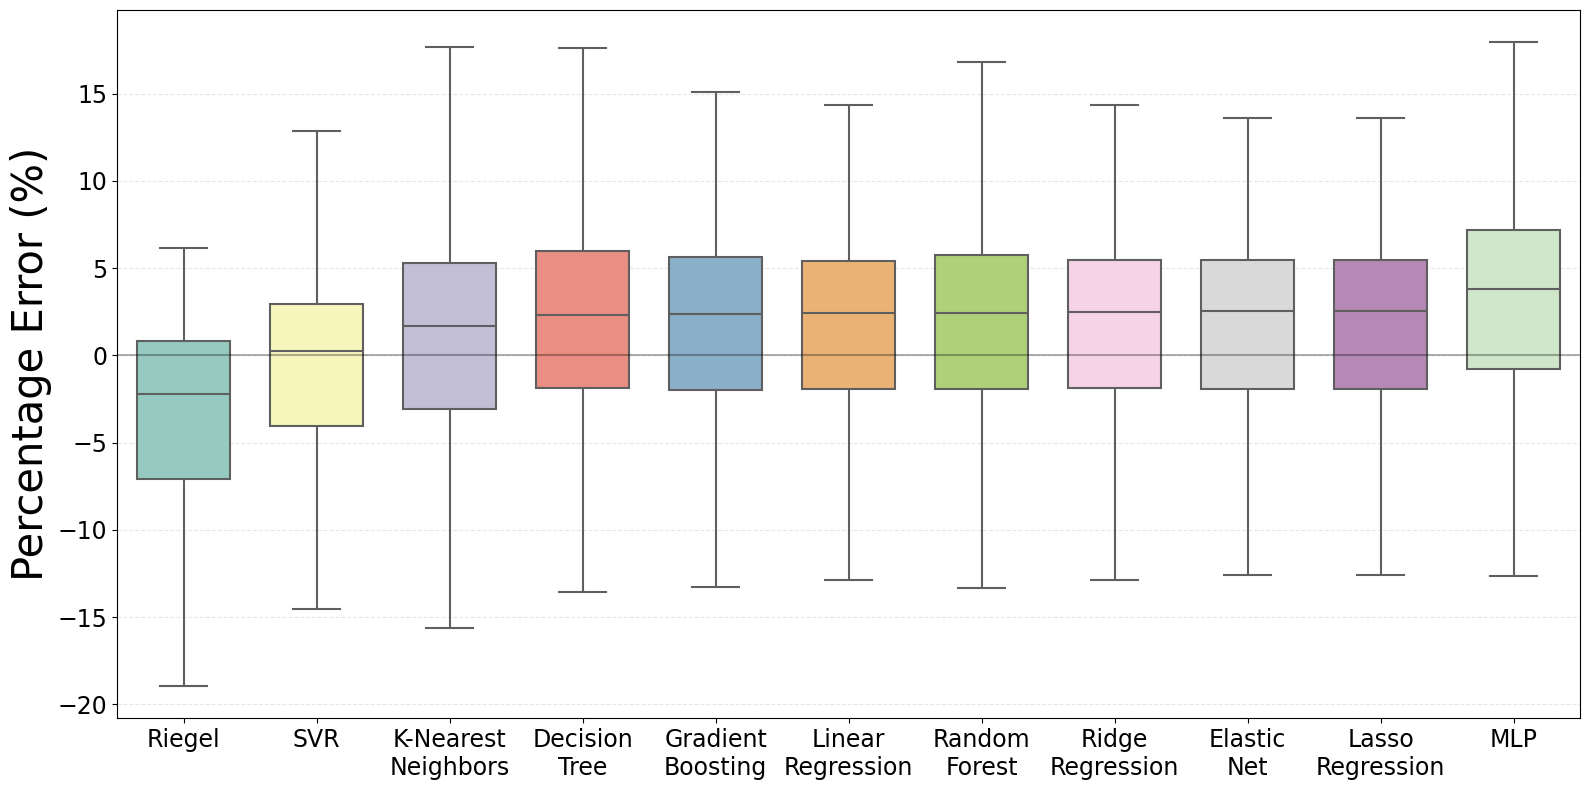

Created boxplot for marathon


C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\2042254280.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


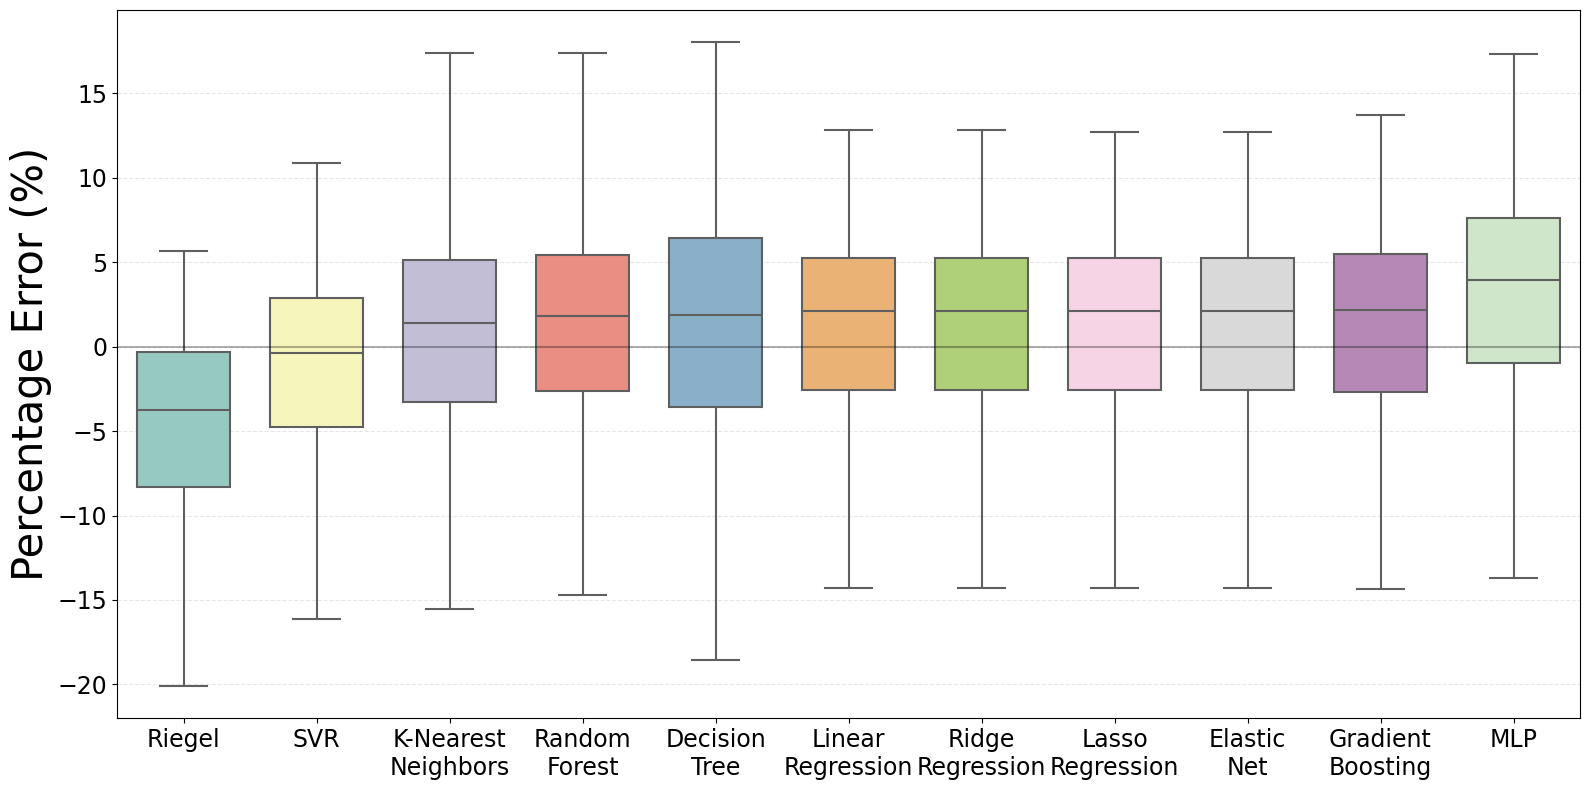

Created boxplot for halfmarathon


C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\2042254280.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(


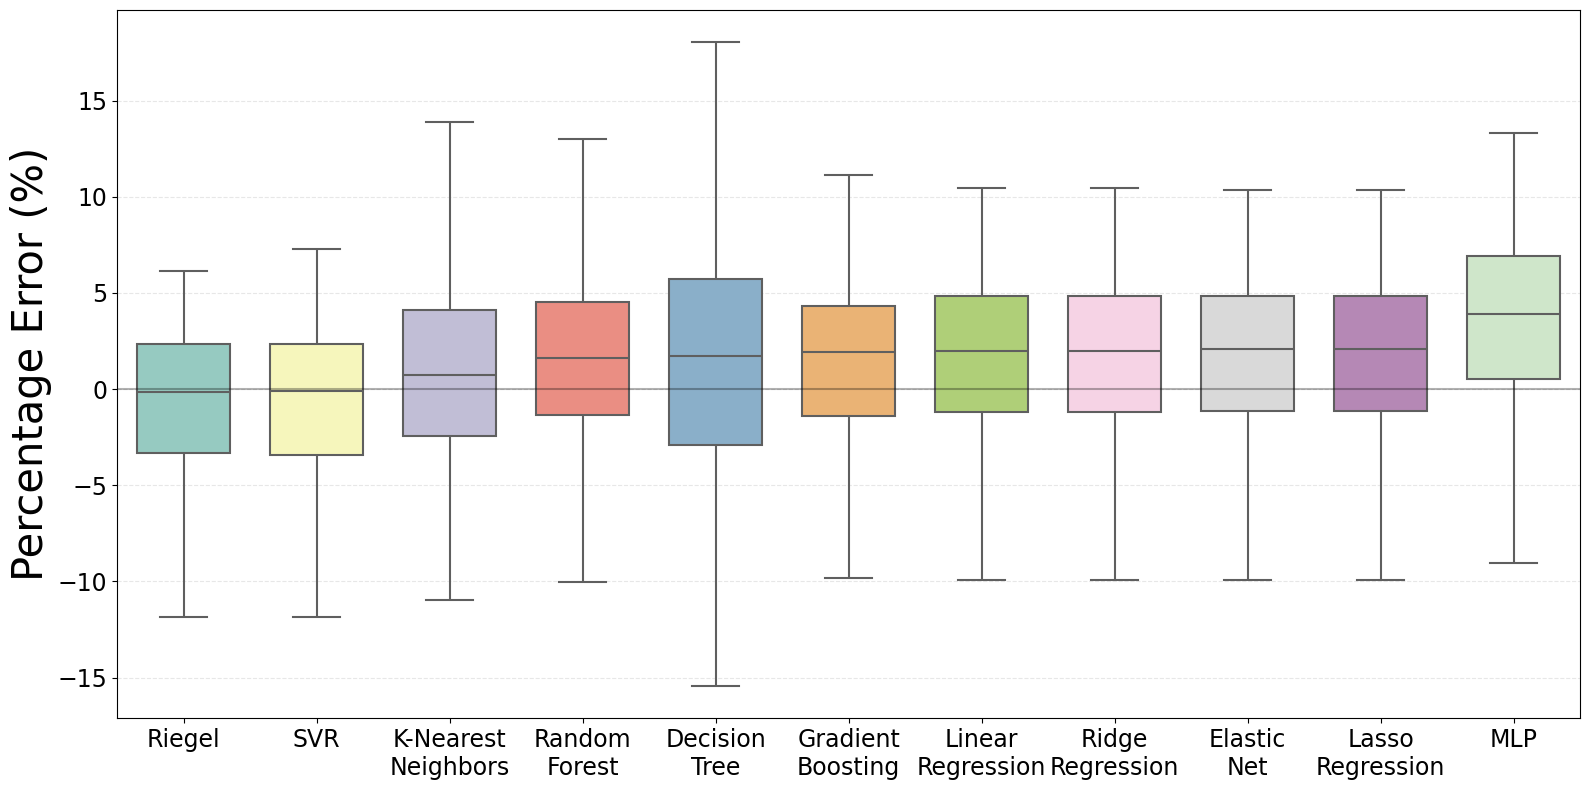

In [100]:
# Create boxplots for each dataset
def create_error_boxplot(dataset_name, results):
    """
    Create and save a boxplot showing error distributions for different models.

    Args:
        dataset_name (str): Name of the dataset ('whole', 'marathon', or 'halfmarathon')
        results (dict): Dictionary containing results for each dataset
    """
    # Get error columns and sort by median error
    error_columns = [col for col in results[dataset_name].columns if col.endswith(' error')]
    median_errors = results[dataset_name][error_columns].median()
    sorted_columns = median_errors.sort_values().index.tolist()

    # Create and configure the plot
    plt.figure(figsize=(16, 8))

    # Create boxplot with custom colors and styling
    box_plot = sns.boxplot(
        data=results[dataset_name][sorted_columns],
        showfliers=False,
        palette='Set3',  # Use a softer color palette
        width=0.7,       # Make boxes slightly narrower
        linewidth=1.5    # Thicker box lines
    )

    # Format axis labels
    plt.xticks(rotation=0, ha='center')
    plt.gca().set_xticklabels(
        [label.get_text().replace(' error', '').replace(' ', '\n')
         for label in plt.gca().get_xticklabels()],
        fontsize=17
    )
    plt.yticks(fontsize=17)
    plt.ylabel('Percentage Error (%)', fontsize=30)

    # Add grid and adjust layout
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)  # Lighter grid
    plt.tight_layout()

    # Add a horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # Save and display
    plt.savefig(f'figs/error_boxplot_{dataset_name}.pdf', bbox_inches='tight')
    print(f'Created boxplot for {dataset_name}')
    plt.show()
    plt.close()

# Create boxplots for each dataset
for dataset_name in ['whole', 'marathon', 'halfmarathon']:
    create_error_boxplot(dataset_name, results)

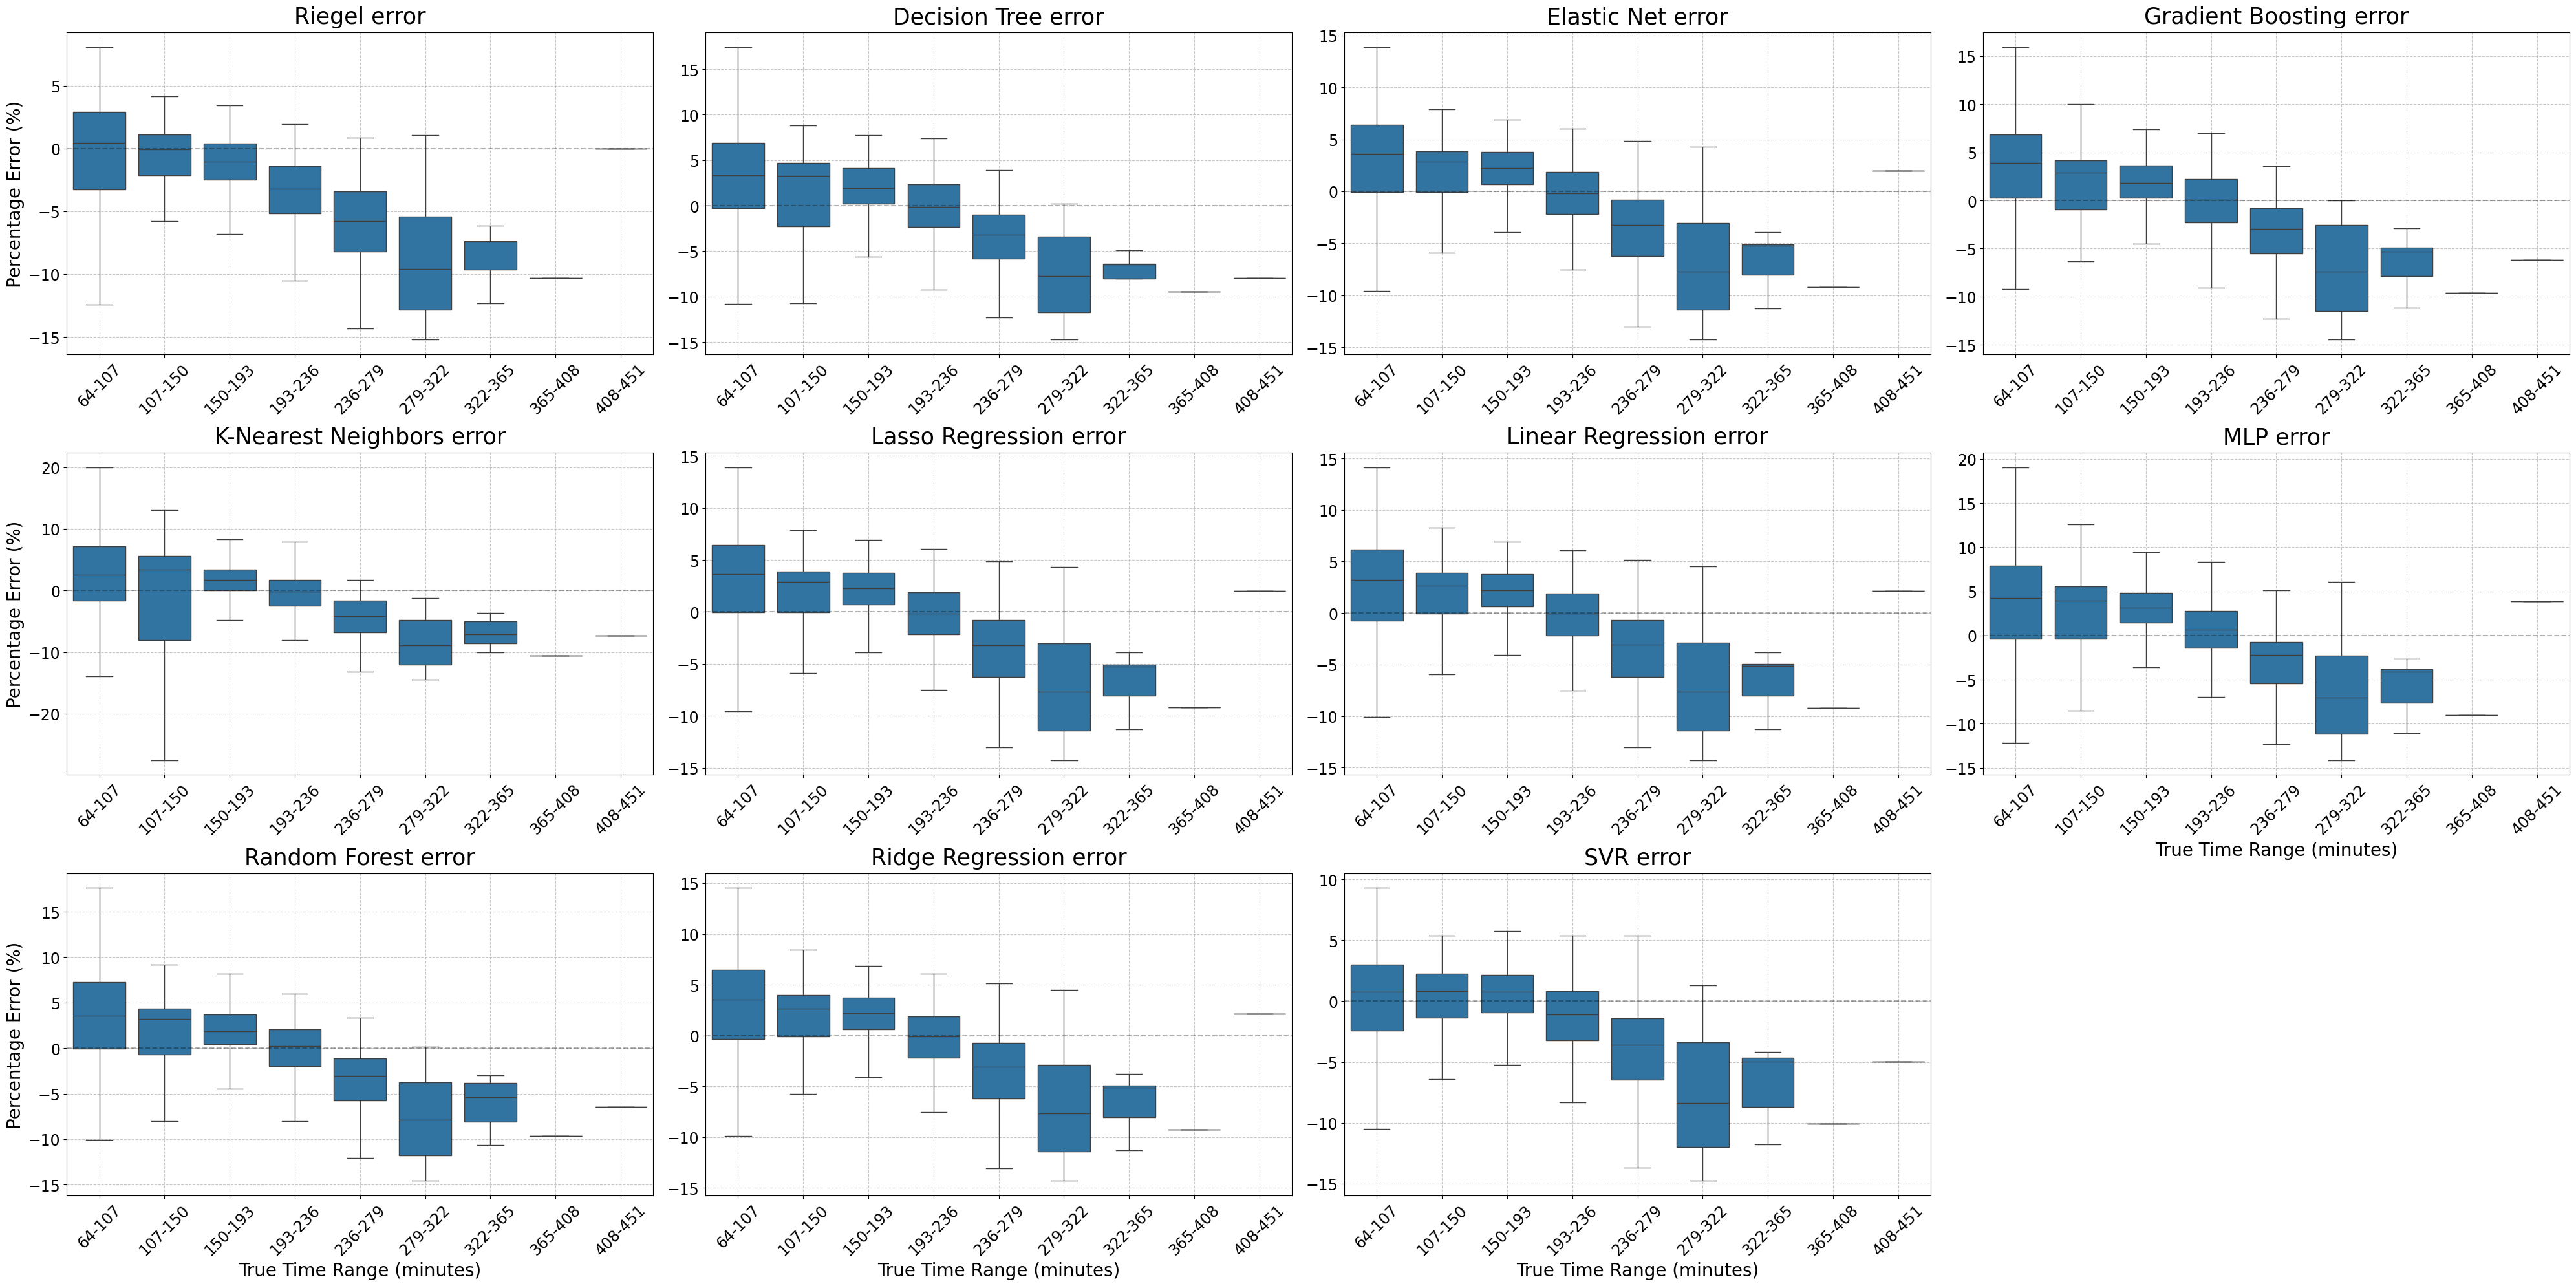

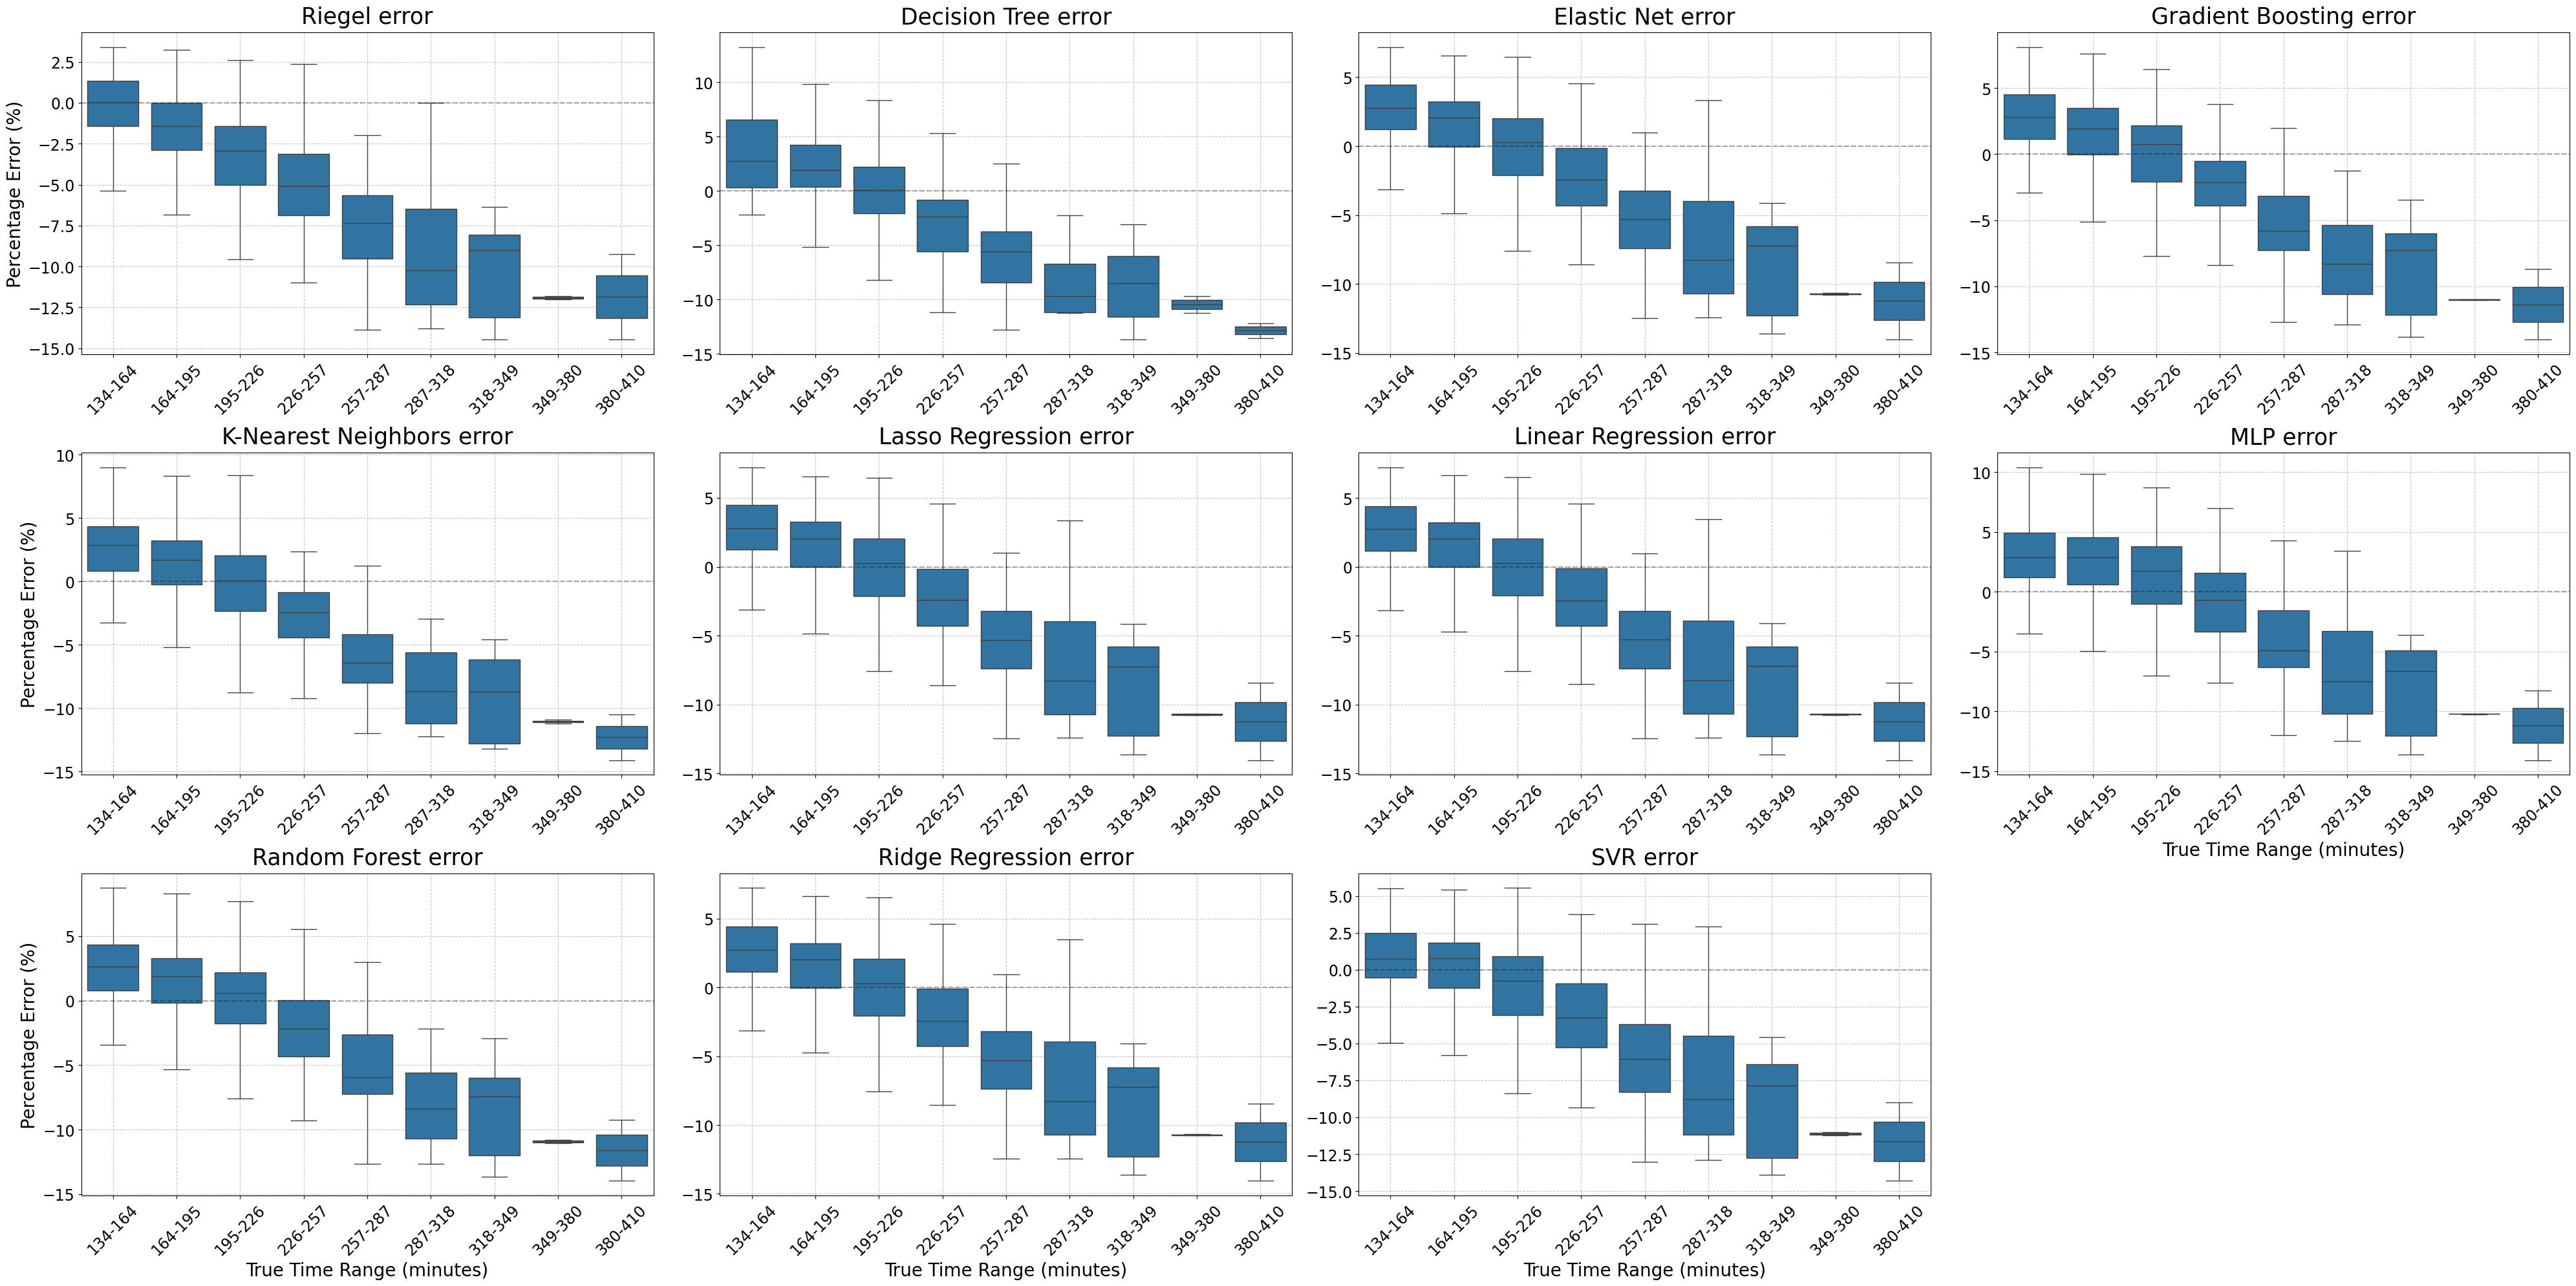

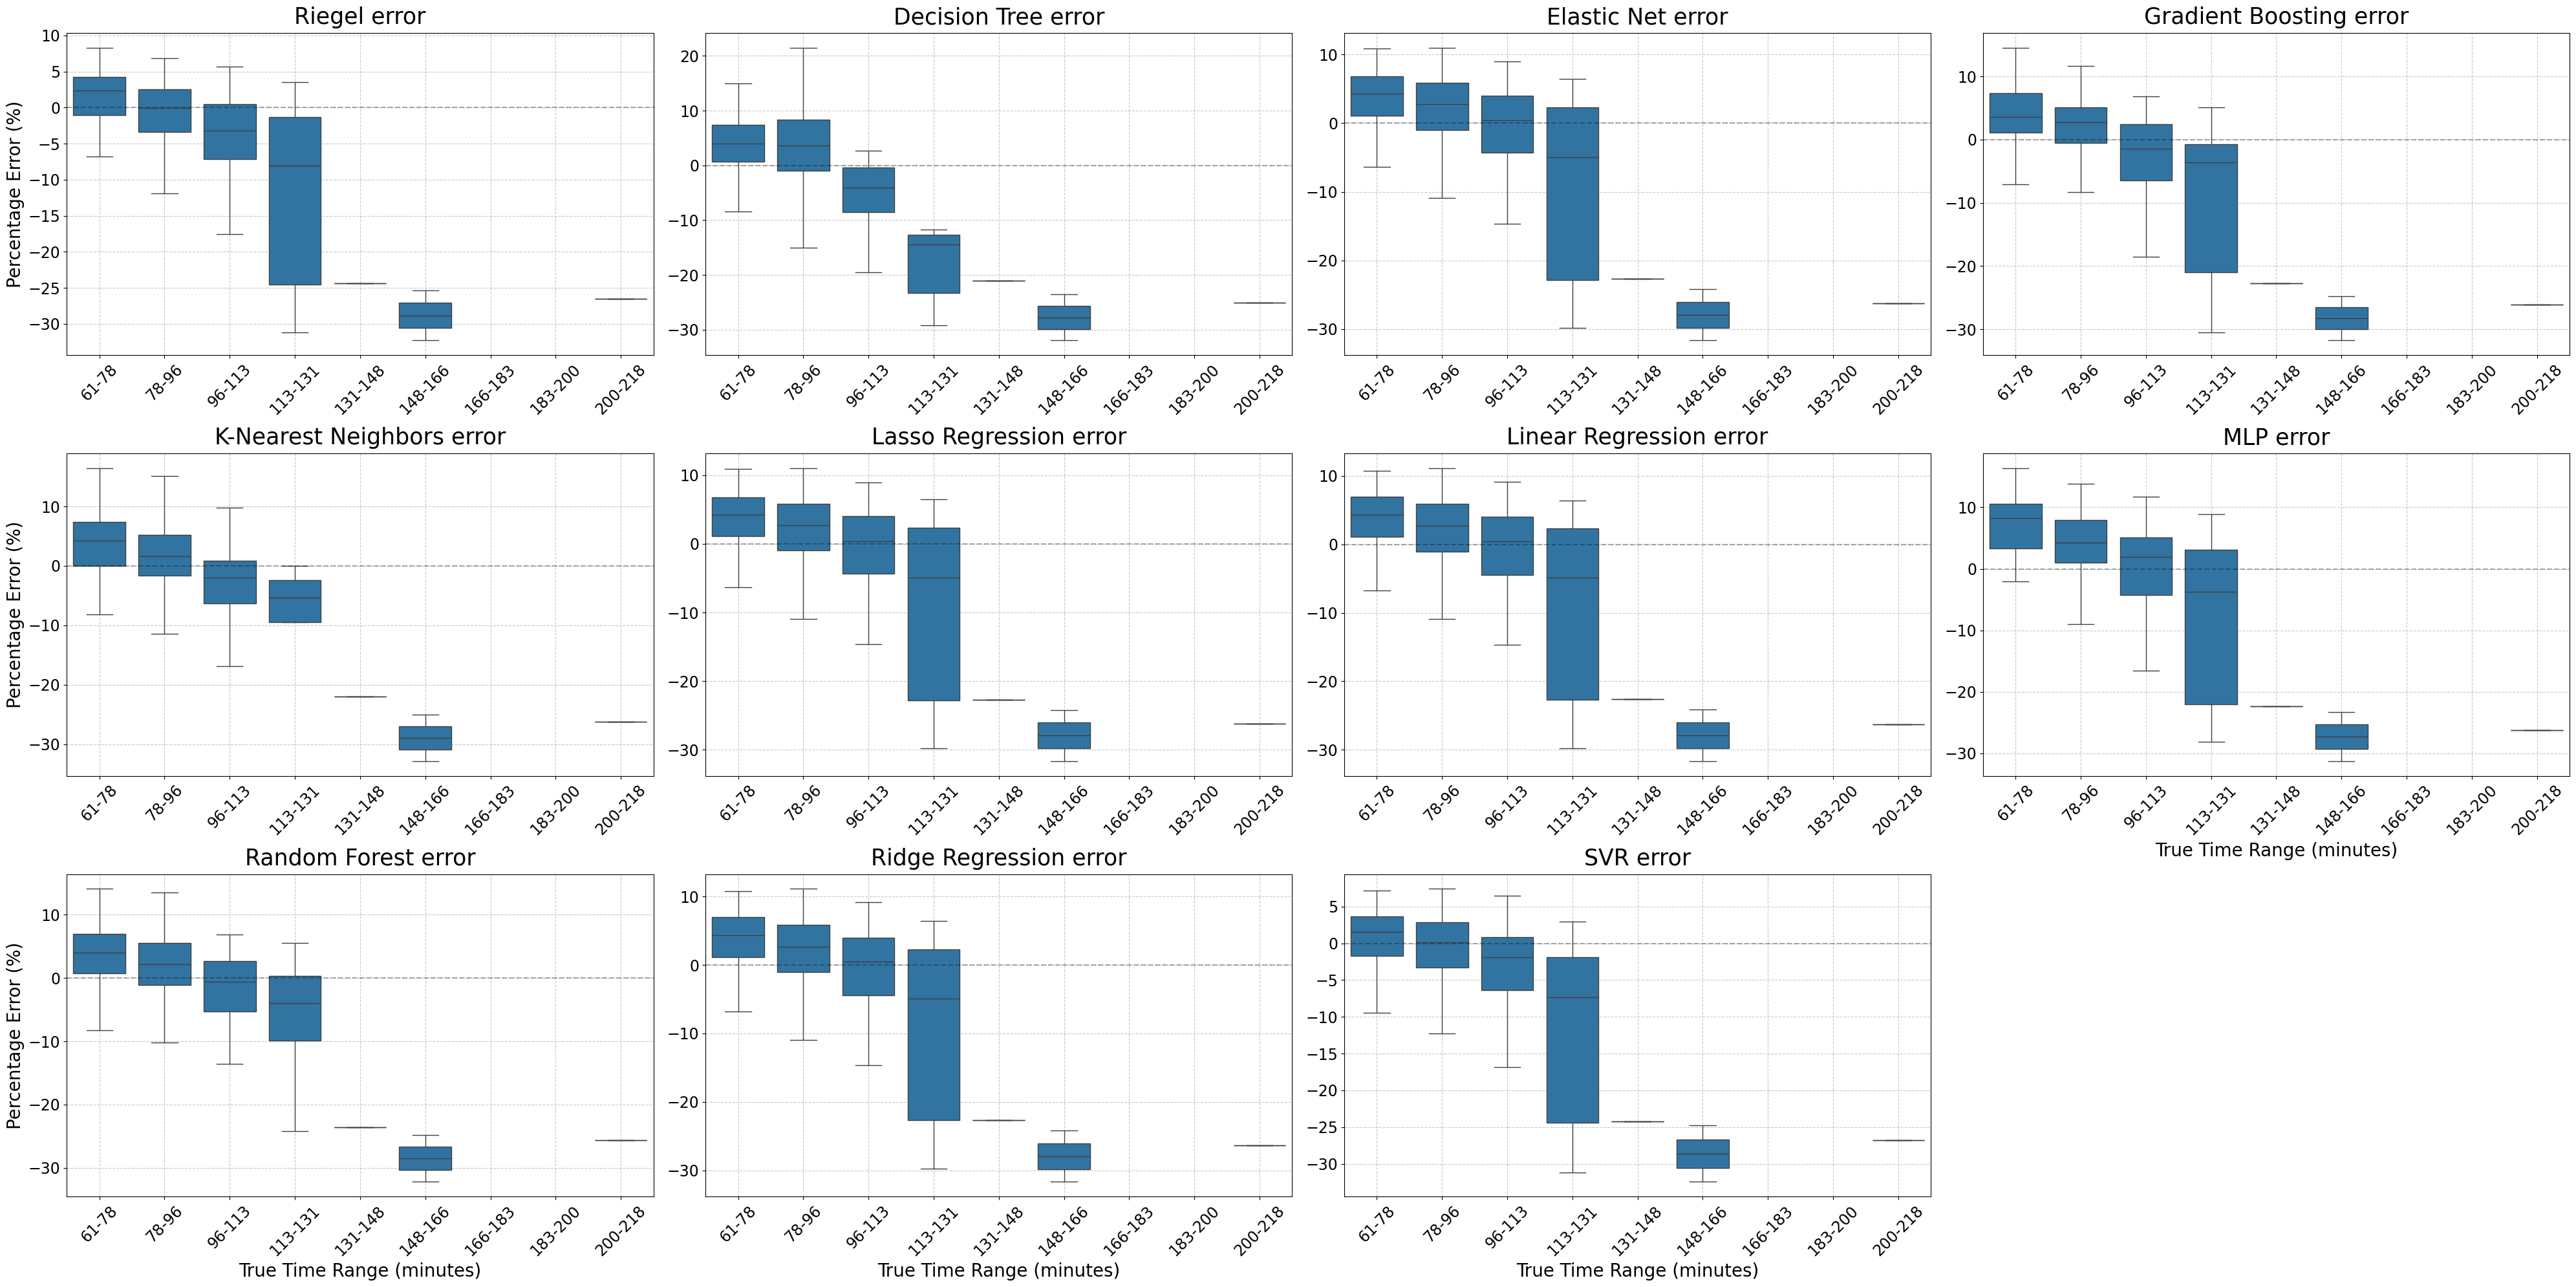

In [106]:
def create_binned_error_analysis(dataset_name, results, n_bins=10):
    """
    Create binned analysis of errors vs true values using boxplots for a given dataset.

    Args:
        dataset_name (str): Name of the dataset ('whole', 'marathon', or 'halfmarathon')
        results (dict): Dictionary containing results for each dataset
        n_bins (int): Number of bins to create
    """
    # Get error columns
    error_columns = [col for col in results[dataset_name].columns if col.endswith(' error')]

    # Create bins for true values
    bins = np.linspace(results[dataset_name]['true_value'].min(),
                      results[dataset_name]['true_value'].max(),
                      n_bins)
    results[dataset_name]['true_value_bin'] = pd.cut(results[dataset_name]['true_value'], bins=bins)

    # Calculate layout
    n_models = len(error_columns)
    n_cols = 4#2  # Changed to 2 columns
    n_rows = (n_models + n_cols - 1) // n_cols

    # Create figure with adjusted size for 2 columns
    plt.figure(figsize=(40, 20))  # Adjusted figure size

    for i, error_col in enumerate(error_columns, 1):
        plt.subplot(n_rows, n_cols, i)

        # Calculate percentage error
        results[dataset_name]['percentage_error'] = (results[dataset_name][error_col] /
                                                   results[dataset_name]['true_value']) * 100

        # Create boxplot
        sns.boxplot(data=results[dataset_name],
                   x='true_value_bin',
                   y='percentage_error',
                   showfliers=False)

        # Add reference line
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)

        # Customize plot with larger fonts
        model_name = error_col.replace('model_', '').replace('_error', '')
        plt.title(f'{model_name}', fontsize=25, pad=10)

        # Only show x label on bottom plots
        if i > n_models - n_cols:
            plt.xlabel('True Time Range (minutes)', fontsize=20)
        else:
            plt.xlabel('')

        # Only show y label on left plots
        if i % n_cols == 1:
            plt.ylabel('Percentage Error (%)', fontsize=20)
        else:
            plt.ylabel('')

        # Format x-axis labels with larger font size
        plt.xticks(range(len(bins)-1),
                  [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)],
                  rotation=45,
                  fontsize=17)

        # Format y-axis labels with larger font size
        plt.yticks(fontsize=17)

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add mean value annotations with larger font size
        for j in range(len(bins)-1):
            bin_data = results[dataset_name][
                results[dataset_name]['true_value_bin'] == pd.Interval(bins[j], bins[j+1])
            ]['percentage_error']
            mean_val = bin_data.mean()
            plt.text(j, mean_val, f'{mean_val:.1f}%',
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=17)

    plt.tight_layout()

    # Save figure
    plt.savefig(f'binned_error_analysis_{dataset_name}.svg', bbox_inches='tight',transparent=True)
    plt.show()
    plt.close()

# Create analysis for each dataset
for dataset_name in ['whole', 'marathon', 'halfmarathon']:
    create_binned_error_analysis(dataset_name, results)

# Some plots

C:\Users\karczews\AppData\Local\Temp\ipykernel_30984\1456435956.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = X_train_halfmarathon.replace(['M','F'],[0,1]).drop(columns=['first days before main event','second days before main event','height','weight'])


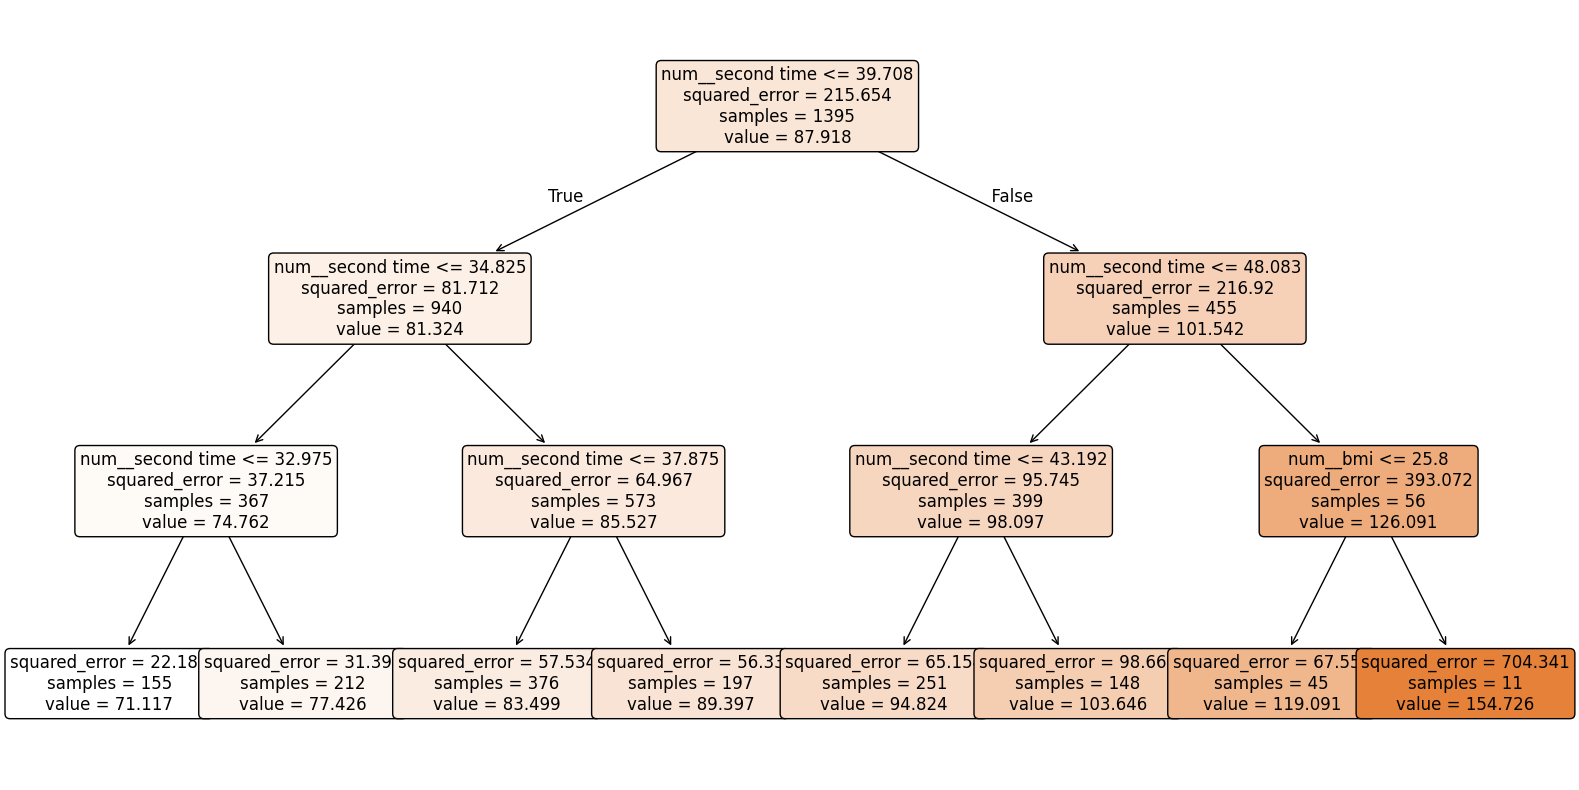

In [104]:
# Create and fit the decision tree
tree = DecisionTreeRegressor(max_depth=3)
x = preprocessor_halfmarathon.fit_transform(X_train_halfmarathon)
x = X_train_halfmarathon.replace(['M','F'],[0,1]).drop(columns=['first days before main event','second days before main event','height','weight'])
tree.fit(x, y_train_halfmarathon)

# Create figure with larger size for better readability
plt.figure(figsize=(20, 10))

# Plot tree with improved styling
plot_tree(tree,
          feature_names=preprocessor_halfmarathon.get_feature_names_out(),
          filled=True,  # Fill nodes with colors
          rounded=True,  # Rounded corners
          fontsize=12,  # Larger font size
          class_names=True,
          impurity=True)



# Save the plot as PDF
plt.savefig('figs/decision_tree.svg', format='svg', bbox_inches='tight', transparent=True)
